# Molecular and cell line covariates

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from math import ceil
from time import time

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.analysis.sublineage_model_analysis import (
    get_sgrna_to_gene_map,
    load_sublineage_model_posteriors,
    sublineage_to_lineage_map,
)
from speclet.data_processing.common import head_tail
from speclet.data_processing.crispr import grouped_copy_number_transform
from speclet.io import DataFile, data_path, tables_dir, temp_dir
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

In [5]:
STASH_DIR = temp_dir() / "100_106_molecular-cellular-covariates_stash"
if not STASH_DIR.exists():
    STASH_DIR.mkdir()

if False:
    for fp in STASH_DIR.iterdir():
        os.remove(fp)

In [6]:
OUTPUT_DIR = tables_dir() / "100_106_molecular-cellular-covariates"
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir()

### Data

#### Model posteriors

In [7]:
postmen = load_sublineage_model_posteriors()

In [8]:
postmen.keys

['bile duct (cholangiocarcinoma)',
 'bile duct (gallbladder adenocarcinoma)',
 'blood (ALL)',
 'blood (AML)',
 'blood (CLL)',
 'blood (CML)',
 'bone (Ewing sarcoma)',
 'bone (chordoma)',
 'bone (osteosarcoma)',
 'breast',
 'central nervous system (glioma)',
 'central nervous system (medulloblastoma)',
 'cervix (cervical carcinoma)',
 'cervix (cervical squamous)',
 'colorectal',
 'esophagus (esophagus adenocarcinoma)',
 'esophagus (esophagus squamous)',
 'eye (uveal melanoma)',
 'gastric (gastric adenocarcinoma)',
 'kidney (renal cell carcinoma)',
 'liver (hepatocellular carcinoma)',
 'lung (NSCLC)',
 'lung (SCLC)',
 'lung (mesothelioma)',
 'lymphocyte (hodgkin lymphoma)',
 'lymphocyte (lymphoma unspecified)',
 'lymphocyte (non hodgkin lymphoma)',
 'ovary (ovary adenocarcinoma)',
 'pancreas',
 'peripheral nervous system (neuroblastoma)',
 'plasma cell (multiple myeloma)',
 'prostate',
 'skin (melanoma)',
 'skin (skin squamous)',
 'soft tissue (ATRT)',
 'soft tissue (liposarcoma)',
 'sof

In [9]:
len(postmen)

43

In [10]:
sub_to_lineage, lineages = sublineage_to_lineage_map(postmen)

In [11]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

### sgRNA information

In [12]:
sgrna_info = get_sgrna_to_gene_map()
sgrna_info.head()

sgrna hugo_symbol sgrna_target_chr  sgrna_target_pos
0  GGAAGTCTGGAGTCTCCAGG        A1BG               19          58353109
1  GTGGACTTCCAGCTACGGCG        A1BG               19          58351569
2  GTGTGCCGAGGTGTGCTGCG        A1BG               19          58352467
3  TCAATGGTCACAGTAGCGCT        A1BG               19          58352307
4  GCAGATAAAACCAAAAACCG        A1CF               10          50836144

### Gene-to-chromosome map

In [13]:
gene_chr_map = (
    sgrna_info.drop(columns=["sgrna"])
    .drop_duplicates()
    .groupby(["hugo_symbol", "sgrna_target_chr"])["sgrna_target_pos"]
    .median()
    .reset_index()
)
assert gene_chr_map["hugo_symbol"].nunique() == len(gene_chr_map)
gene_chr_map.head()

hugo_symbol sgrna_target_chr  sgrna_target_pos
0        A1BG               19        58352387.0
1        A1CF               10        50840175.0
2         A2M               12         9104546.5
3       A2ML1               12         8835899.5
4     A3GALT2                1        33312702.5

### Known essential genes

In [14]:
essential_genes = set(
    pd.read_csv(data_path(DataFile.DEPMAP_ESSENTIALS))
    .query("is_essential")["gene"]
    .unique()
)
len(essential_genes)

1248

## Analysis

In [15]:
def get_variables_posterior_summary(
    pm: PostDataMan, var_names: list[str], stash: bool = True
) -> pd.DataFrame:
    vnames = "-".join(var_names)
    stash_fp = STASH_DIR / f"posterior-summary-df_{pm.id}_var-{vnames}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    try:
        post = (
            pm.posterior_summary.copy()
            .filter_column_isin("var_name", var_names)
            .reset_index(drop=True)
            .assign(lineage_subtype=pm.id)
        )
    except FileNotFoundError:
        print(f"No posterior summary for '{pm.id}'.")
        return pd.DataFrame()
    post.to_csv(stash_fp, index=False)
    return post

In [16]:
def map_subtype_to_lineage(
    df: pd.DataFrame,
    st_map: dict[str, str],
    st_col: str = "lineage_subtype",
    line_col: str = "lineage",
) -> pd.DataFrame:
    df[line_col] = df[st_col].map(st_map)
    return df

### Gene copy number and RNA effects

In [17]:
def _get_rna_and_copynumber_effects(
    pm: PostDataMan, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"cn-rna-posterior-summaries_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    post = get_variables_posterior_summary(pm, var_names=["b", "d"])
    if len(post) == 0:
        return post
    post = post.pipe(
        extract_coords_param_names, col="parameter", names=["hugo_symbol"]
    ).assign(lineage_subtype=pm.id)
    post.to_csv(stash_fp, index=False)
    return post

In [18]:
rna_cn_posterior = (
    pd.concat([_get_rna_and_copynumber_effects(pm) for pm in postmen.posteriors])
    .reset_index(drop=True)
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
    .merge(gene_chr_map, on="hugo_symbol", how="left")
)
rna_cn_posterior.head(5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     b[A1BG] -0.002  0.029    -0.049      0.045        0.0    0.001   
1     b[A1CF]  0.032  0.029    -0.011      0.082        0.0    0.000   
2      b[A2M]  0.032  0.031    -0.018      0.079        0.0    0.000   
3    b[A2ML1]  0.006  0.029    -0.042      0.052        0.0    0.001   
4  b[A3GALT2] -0.051  0.032    -0.102     -0.002        0.0    0.000   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0    8983.0    2342.0    1.0        b  bile duct (cholangiocarcinoma)   
1   10585.0    2707.0    1.0        b  bile duct (cholangiocarcinoma)   
2   11338.0    2856.0    1.0        b  bile duct (cholangiocarcinoma)   
3   10087.0    2801.0    1.0        b  bile duct (cholangiocarcinoma)   
4   11099.0    2648.0    1.0        b  bile duct (cholangiocarcinoma)   

  hugo_symbol    lineage sgrna_target_chr  sgrna_target_pos  
0        A1BG  bile duct               19        58352387.0  
1        A1CF  bile duct               10        50840175.0  
2         A2M  bile duct               12         9104546.5  
3       A2ML1  bile duct               12         8835899.5  
4     A3GALT2  bile duct                1        33312702.5

In [19]:
rna_cn_posterior.to_csv(
    OUTPUT_DIR / "rna-copynumber-posterior-summaries.csv", index=False
)

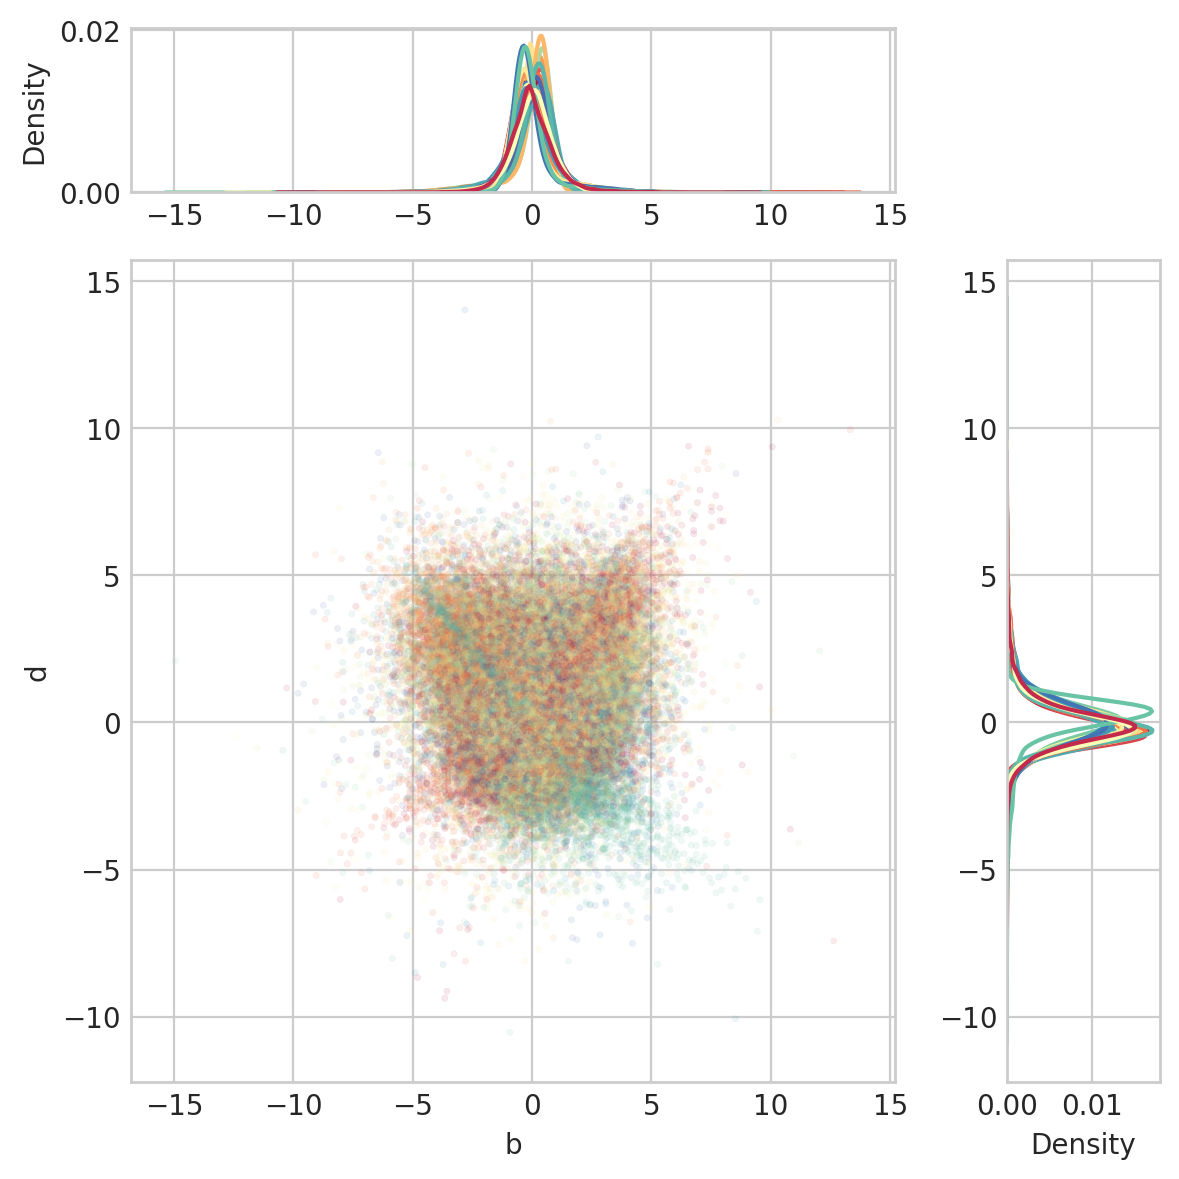

In [20]:
def _z_scale_bd(df: pd.DataFrame) -> pd.DataFrame:
    for x in ["b", "d"]:
        df[x] = (df[x] - df[x].mean()) / df[x].std()
    return df


rna_cn_posterior_pivot = (
    rna_cn_posterior.pivot_wider(
        ["hugo_symbol", "lineage", "lineage_subtype"],
        names_from="var_name",
        values_from="mean",
    )
    .groupby(["lineage_subtype"])
    .apply(_z_scale_bd)
    .sample(frac=1)
)

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=(5, 1), height_ratios=(1, 5))
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

sns.scatterplot(
    data=rna_cn_posterior_pivot,
    x="b",
    y="d",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax,
    s=5,
    alpha=0.1,
    edgecolor=None,
    legend=False,
)

sns.kdeplot(
    data=rna_cn_posterior_pivot,
    x="b",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax_histx,
    legend=False,
)
ax_histx.set_xlabel(None)

sns.kdeplot(
    data=rna_cn_posterior_pivot,
    y="d",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax_histy,
    legend=False,
)
ax_histy.set_ylabel(None)

fig.tight_layout()
plt.show()

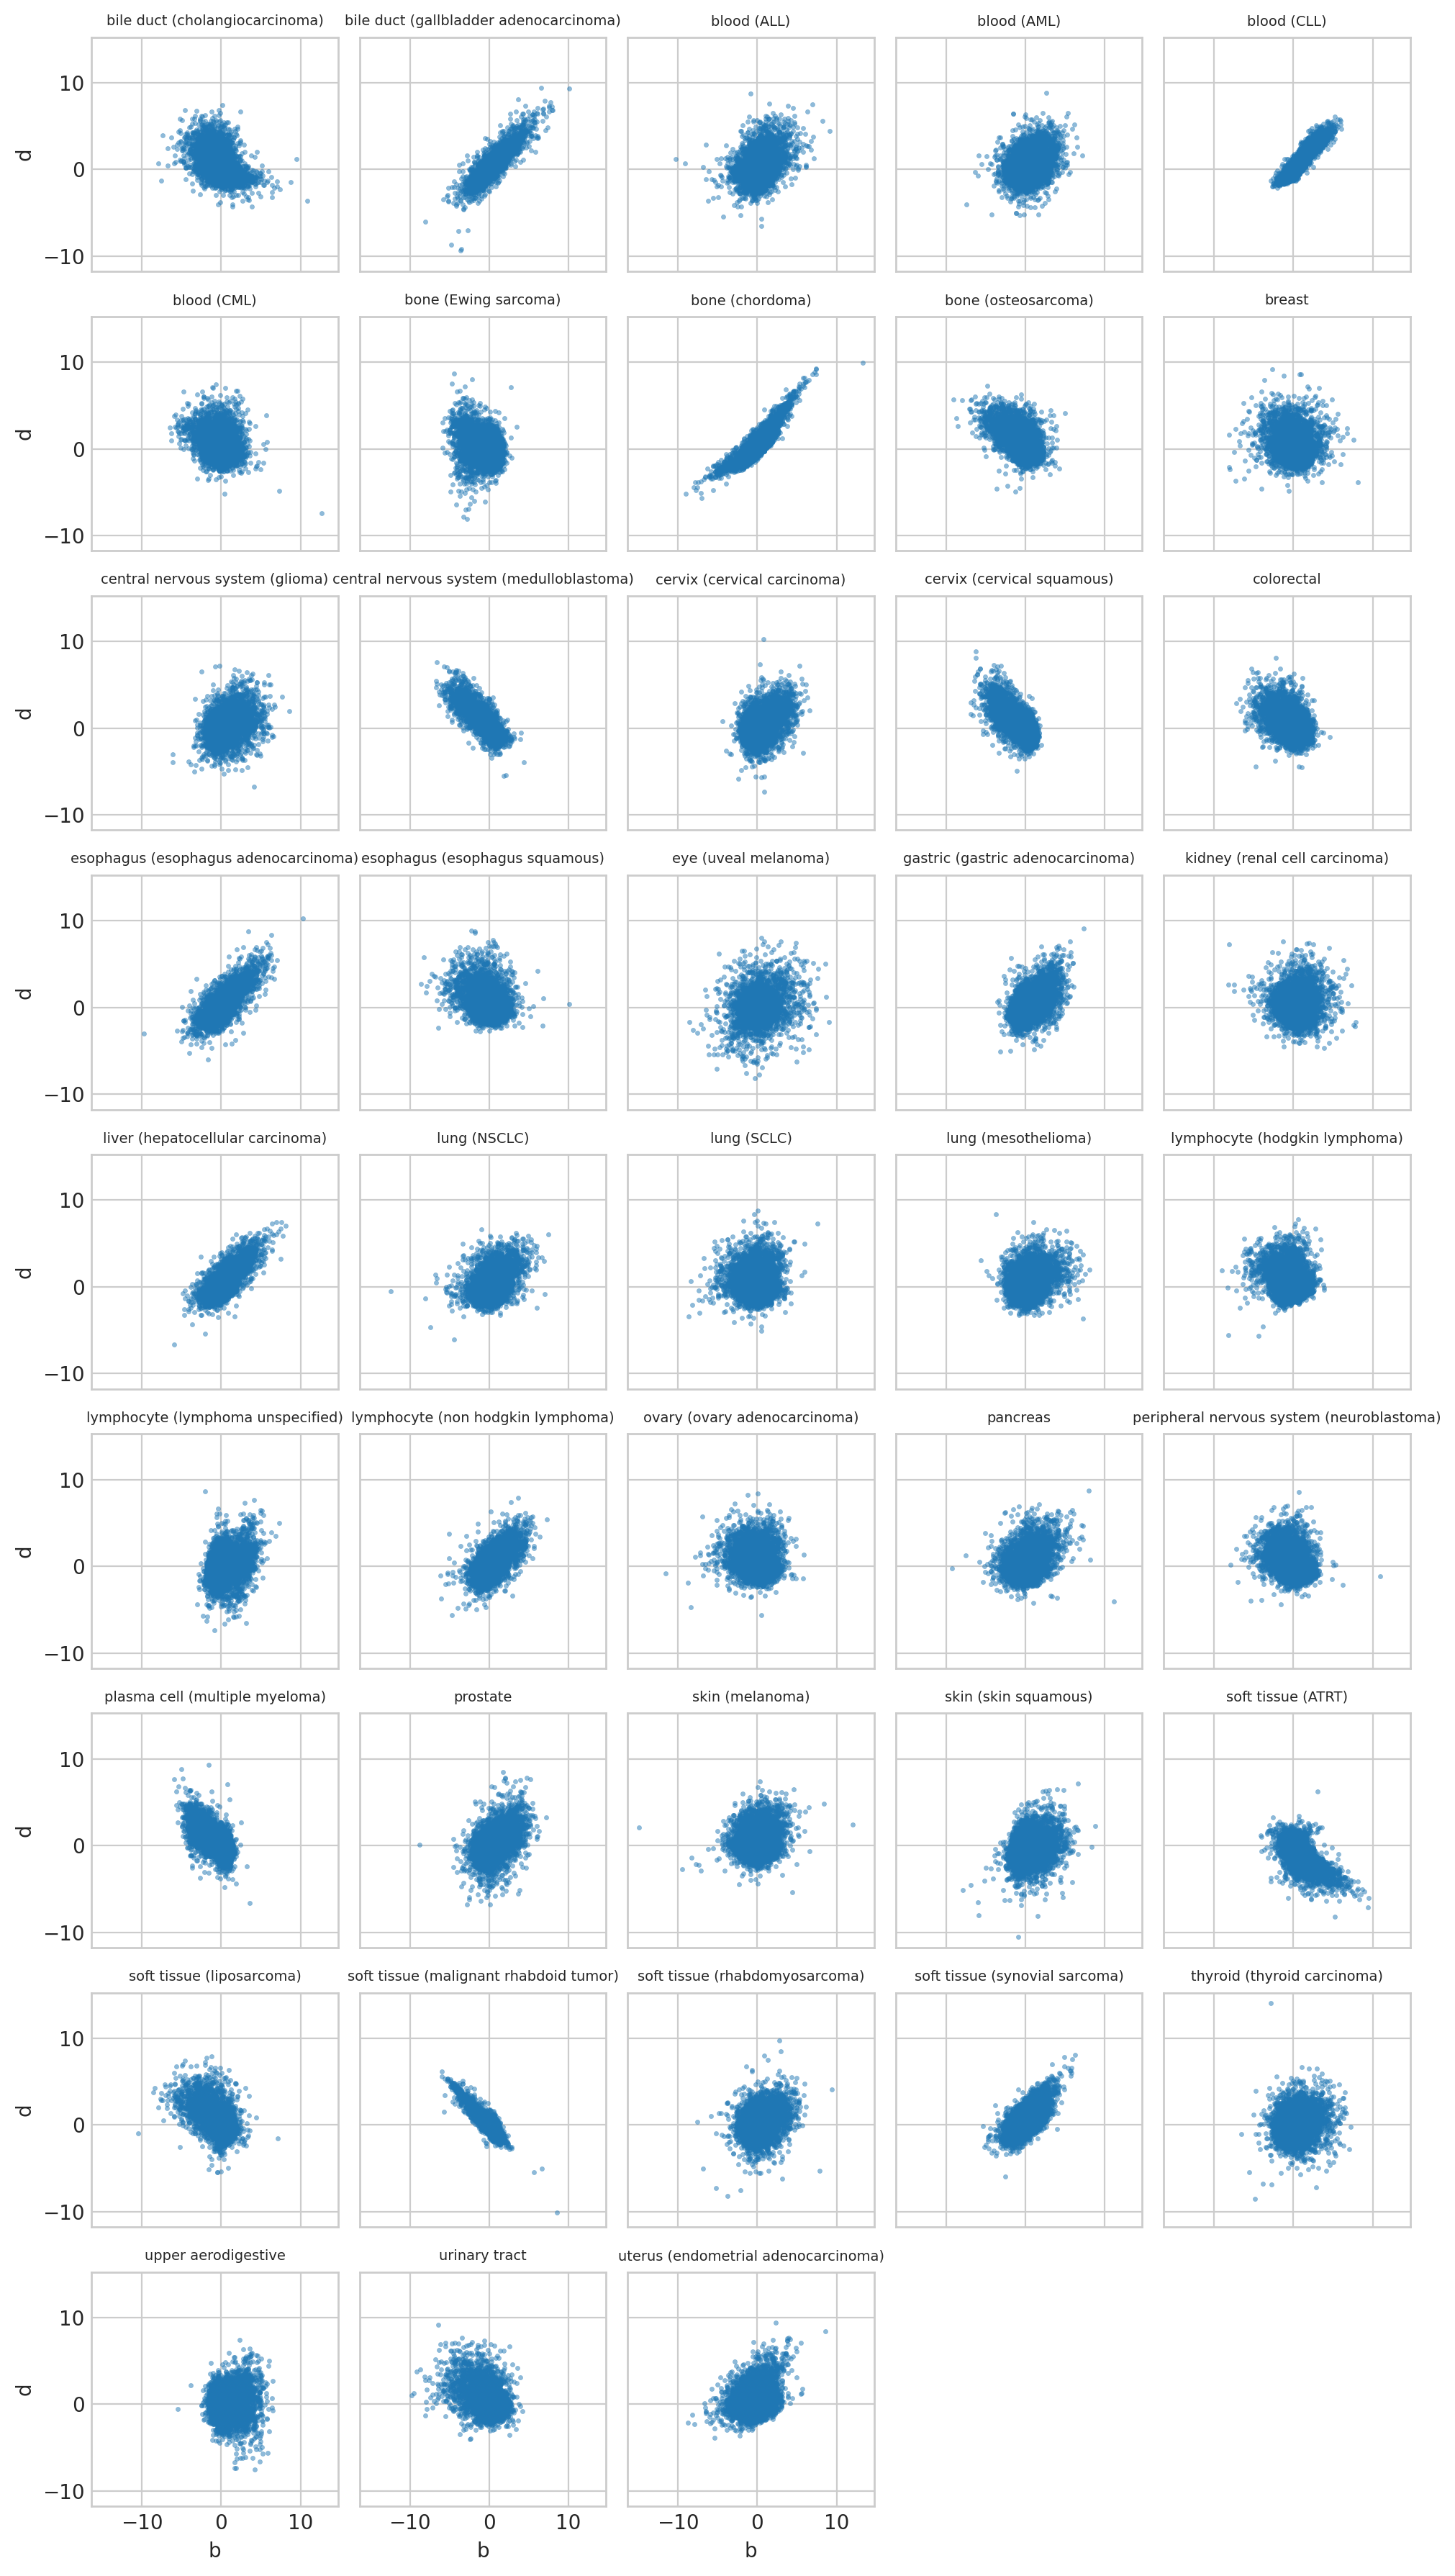

In [21]:
n_sublines = rna_cn_posterior_pivot["lineage_subtype"].nunique()
ncols = 5
nrows = ceil(n_sublines / ncols)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2 * nrows), sharex=True, sharey=True
)
for ax, (st, data_st) in zip(
    axes.flatten(), rna_cn_posterior_pivot.groupby(["lineage_subtype"])
):
    ax.set_title(st, size=7)
    sns.scatterplot(data=data_st, x="b", y="d", ax=ax, s=5, alpha=0.5, edgecolor=None)

for ax in axes.flatten()[n_sublines:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

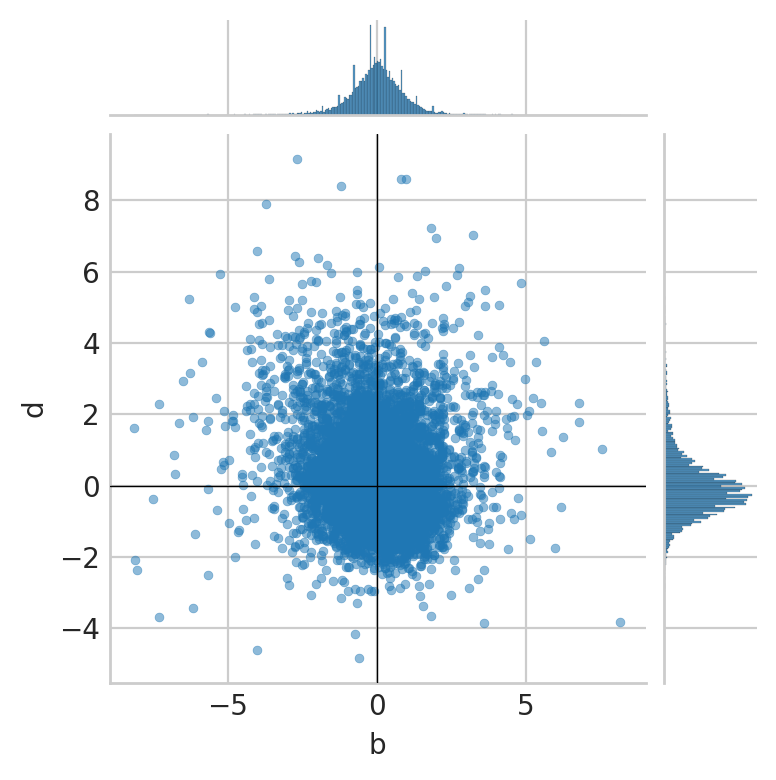

In [22]:
plt_df = rna_cn_posterior_pivot.query("lineage_subtype == 'breast'").reset_index(
    drop=True
)
jp = sns.jointplot(
    data=plt_df,
    x="b",
    y="d",
    marginal_kws={"binwidth": 0.05},
    edgecolor=None,
    alpha=0.5,
    s=10,
    height=4,
    zorder=10,
)
ax = jp.ax_joint
ax.axhline(0, c="k", lw=0.5, zorder=20)
ax.axvline(0, c="k", lw=0.5, zorder=20)
plt.show()

In [23]:
def _get_copy_number_data(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"copy-number-median_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    res = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            usecols=["hugo_symbol", "depmap_id", "copy_number"],
        )
        .assign(copy_number_adj=lambda d: (2 ** d["copy_number"]) - 1)
        .compute()
        .assign(lineage_subtype=pm.id)
    )
    res.to_csv(stash_fp, index=False)
    return res

In [24]:
TEST_CHR = "2"
lung_df = (
    rna_cn_posterior.query(f"sgrna_target_chr == '{TEST_CHR}'")
    .filter_string("lineage_subtype", "lung")
    .reset_index(drop=True)
)

In [25]:
lung_cn_data = pd.concat(
    [
        _get_copy_number_data(postmen[st], stash=True)
        for st in lung_df["lineage_subtype"].unique()
    ]
).reset_index(drop=True)

In [26]:
lung_cn_data = lung_cn_data.pipe(
    grouped_copy_number_transform,
    group=["hugo_symbol", "lineage_subtype"],
    cn_col="copy_number",
    new_col="cn_gene",
    max_cn=3,
)

In [27]:
lung_gene_cn_mean = (
    lung_cn_data.groupby(["hugo_symbol", "lineage_subtype"])["cn_gene"]
    .mean()
    .reset_index(drop=False)
    .rename(columns={"cn_gene": "cn_gene_mean"})
)

In [28]:
def _moving_average_over_chrom(df: pd.DataFrame, w: int = 10) -> pd.DataFrame:
    df["y_avg"] = df["y"].rolling(w, center=True).median()
    return df

In [29]:
lung_df = (
    lung_df.merge(lung_gene_cn_mean, on=["hugo_symbol", "lineage_subtype"])
    .assign(y=lambda d: d["mean"] * d["cn_gene_mean"])
    .sort_values(["lineage_subtype", "sgrna_target_chr", "sgrna_target_pos"])
    .reset_index(drop=True)
    .groupby("lineage_subtype")
    .apply(_moving_average_over_chrom, w=100)
)

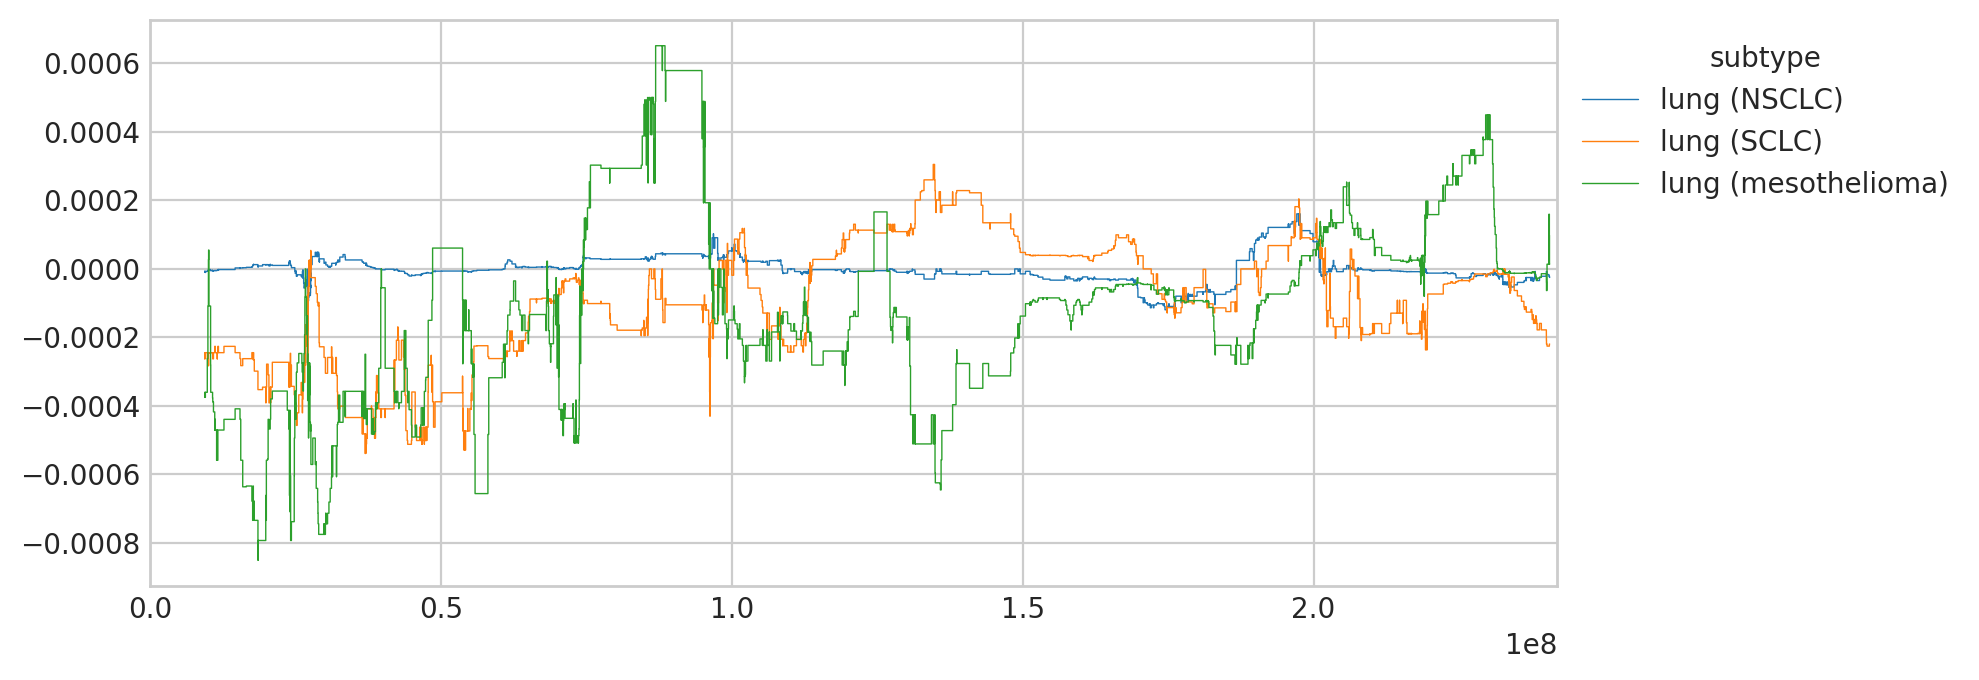

In [30]:
_, ax = plt.subplots(figsize=(10, 3.5))

for st, data_st in lung_df.groupby("lineage_subtype"):
    # ax.scatter(
    #     data_st["sgrna_target_pos"],
    #     data_st["y"],
    #     s=1,
    #     alpha=0.1,
    #     marker="o",
    #     edgecolor=None,
    #     label=st,
    # )
    ax.step(data_st["sgrna_target_pos"], data_st["y_avg"], lw=0.5, label=st)

# ax.set_ylim(-ylim * 1.02, ylim * 1.02)
ax.set_xlim(0, lung_df["sgrna_target_pos"].max())
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="subtype")
plt.tight_layout()
plt.show()

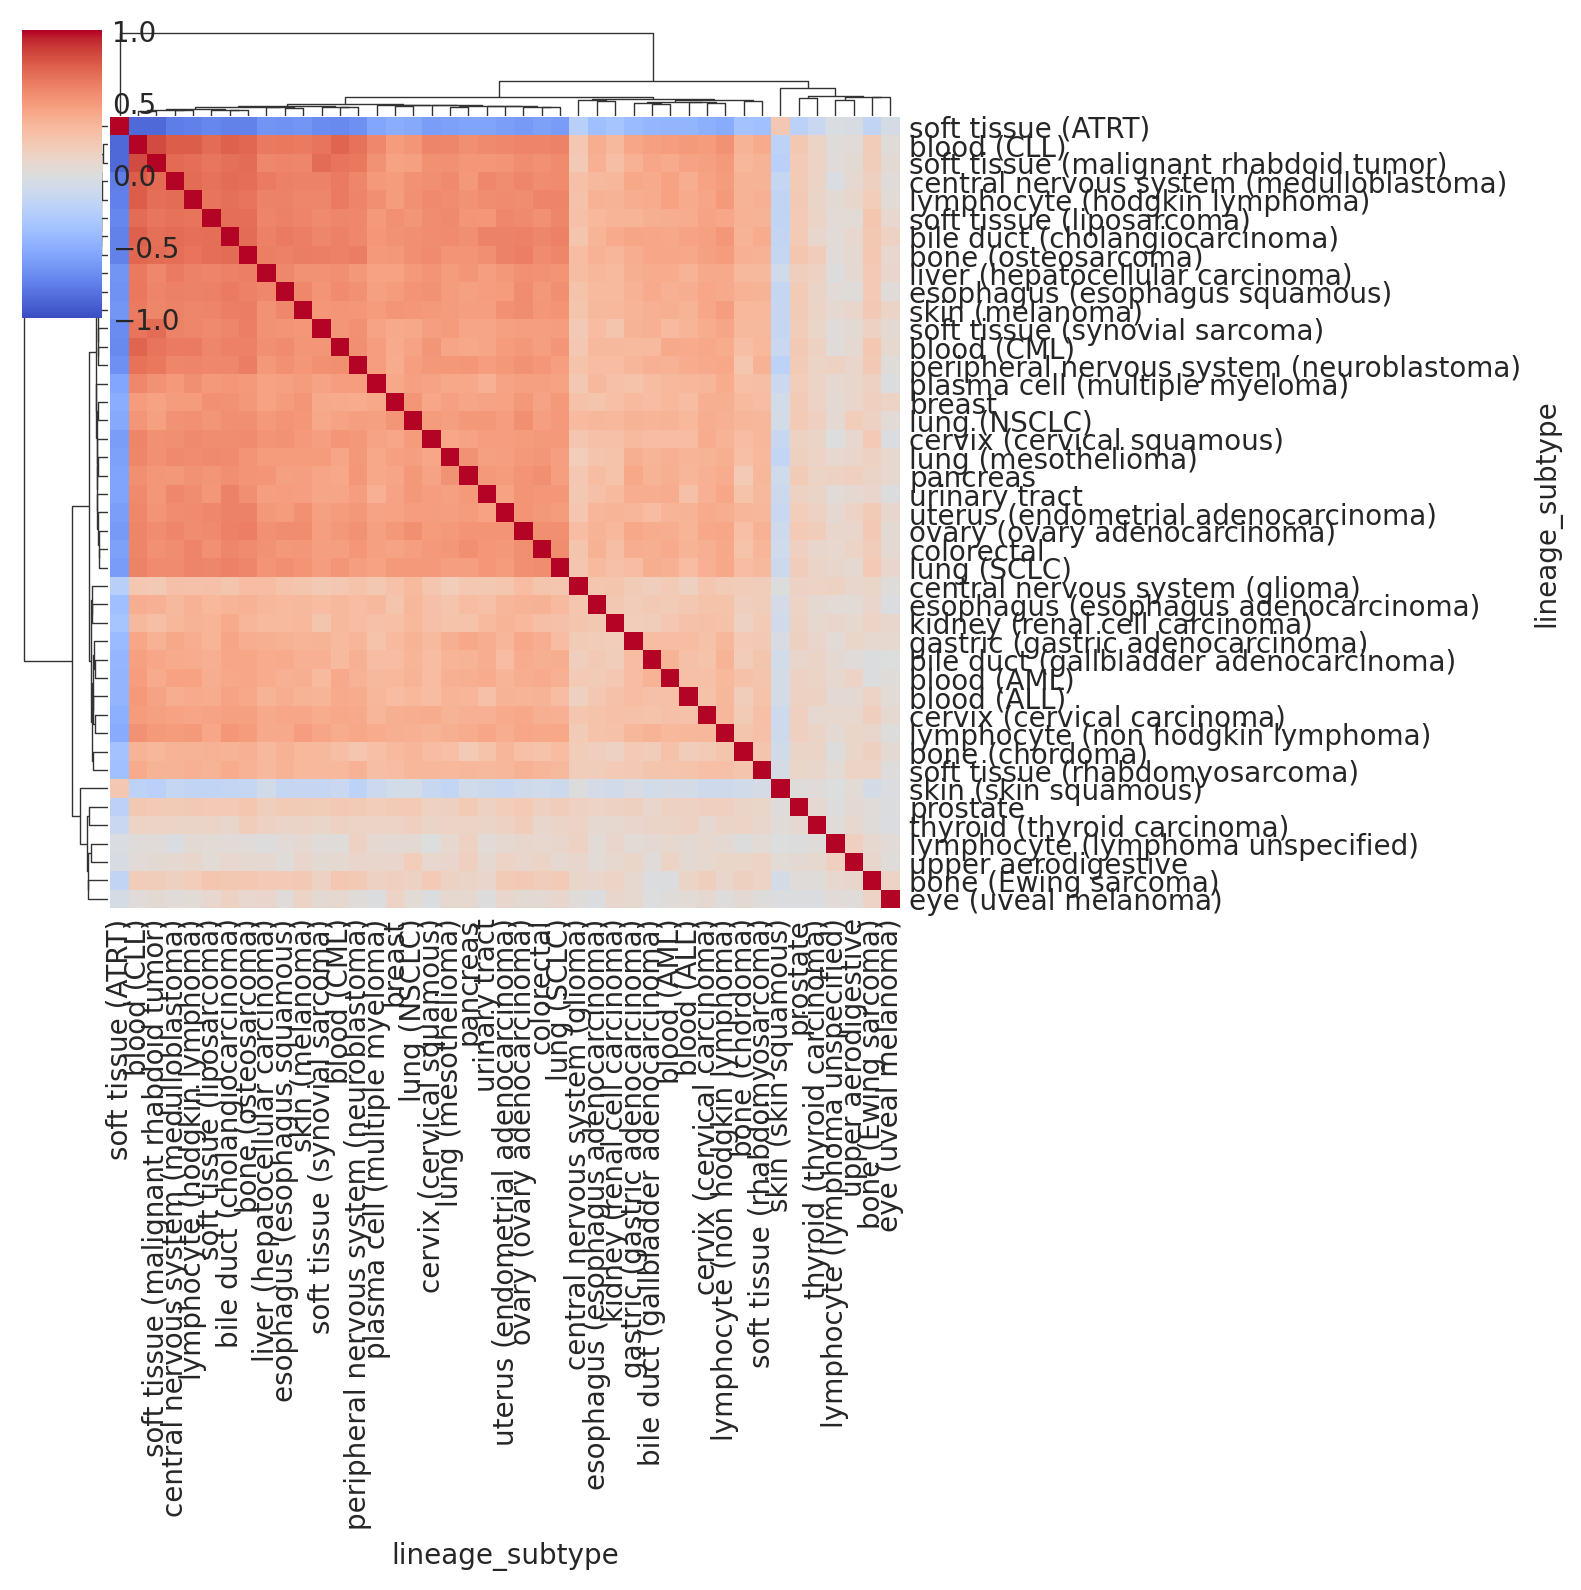

In [31]:
cn_matrix = (
    rna_cn_posterior.copy()
    .query("var_name == 'd'")
    .pivot_wider(["lineage_subtype"], names_from="hugo_symbol", values_from="mean")
    .set_index("lineage_subtype")
)

cn_variances = cn_matrix.var()
top_var_genes = cn_variances[cn_variances >= np.quantile(cn_variances, q=0.8)].index
cn_matrix = cn_matrix[top_var_genes]

sns.clustermap(
    cn_matrix.T.corr(),
    figsize=(8, 8),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    xticklabels=1,
    yticklabels=1,
)
plt.show()

In [32]:
def _assign_rank(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df.sort_values("mean")
        .reset_index(drop=True)
        .assign(rank=np.arange(len(df)) / len(df))
    )
    return df


ranked_genes = (
    rna_cn_posterior.groupby(["lineage_subtype", "var_name"])
    .apply(_assign_rank)
    .reset_index(drop=True)
)

total_ranked_genes = (
    ranked_genes.copy()
    .groupby(["hugo_symbol", "var_name"])["rank"]
    .median()
    .reset_index(drop=False)
    .sort_values(["var_name", "rank", "hugo_symbol"], ascending=(True, False, True))
    .reset_index(drop=True)
    .assign(is_essential=lambda d: d["hugo_symbol"].isin(essential_genes))
)
total_ranked_genes.head()

hugo_symbol var_name      rank  is_essential
0    TIMELESS        b  0.972184          True
1       PSMD6        b  0.964844          True
2      POLR2I        b  0.961532          True
3       CDC45        b  0.952536          True
4       SNRPF        b  0.951708          True

In [33]:
total_ranked_genes.groupby("var_name").pipe(head_tail, n=5).sort_values(
    ["var_name", "rank"]
)

hugo_symbol var_name      rank  is_essential
18118        MDM2        b  0.031017         False
18117       CCND1        b  0.037364         False
18116       CFLAR        b  0.046802         False
18115        NPM1        b  0.049009         False
18114      TIPARP        b  0.049782         False
4           SNRPF        b  0.951708          True
3           CDC45        b  0.952536          True
2          POLR2I        b  0.961532          True
1           PSMD6        b  0.964844          True
0        TIMELESS        b  0.972184          True
36237       CCND1        d  0.100889         False
36236      CDKN2B        d  0.141509         False
36235   KRTAP12-2        d  0.141840         False
36234       PTPRD        d  0.150063         False
36233        SBF1        d  0.151333         False
18123       RBM8A        d  0.987251         False
18122        RPL6        d  0.988189         False
18121      DONSON        d  0.989403          True
18120         RAN        d  0.991004          True
18119       RPS3A        d  0.992660         False

In [34]:
total_ranked_genes.to_csv(OUTPUT_DIR / "total-ranked-genes-copynumber.csv", index=False)

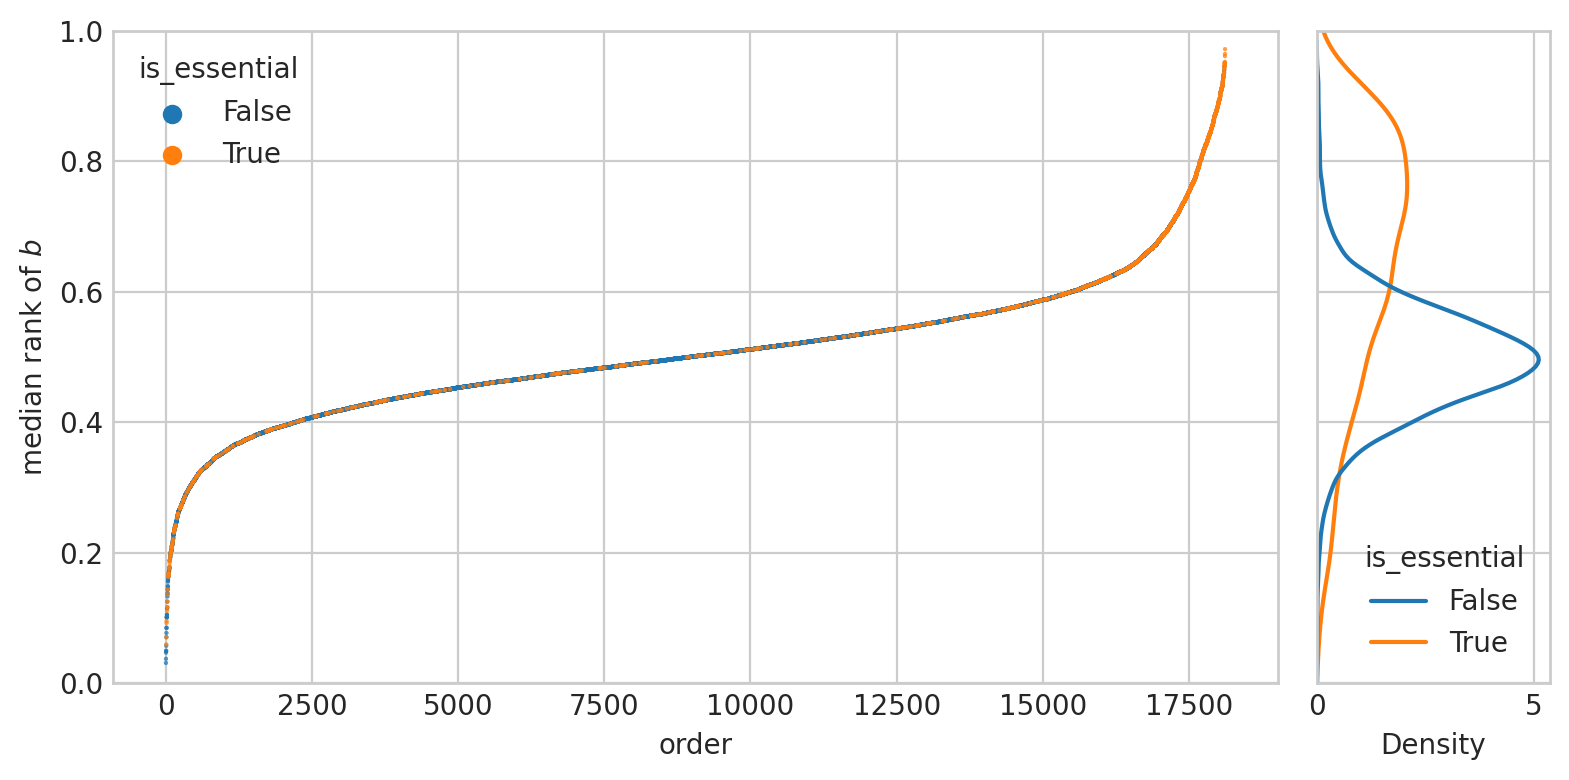

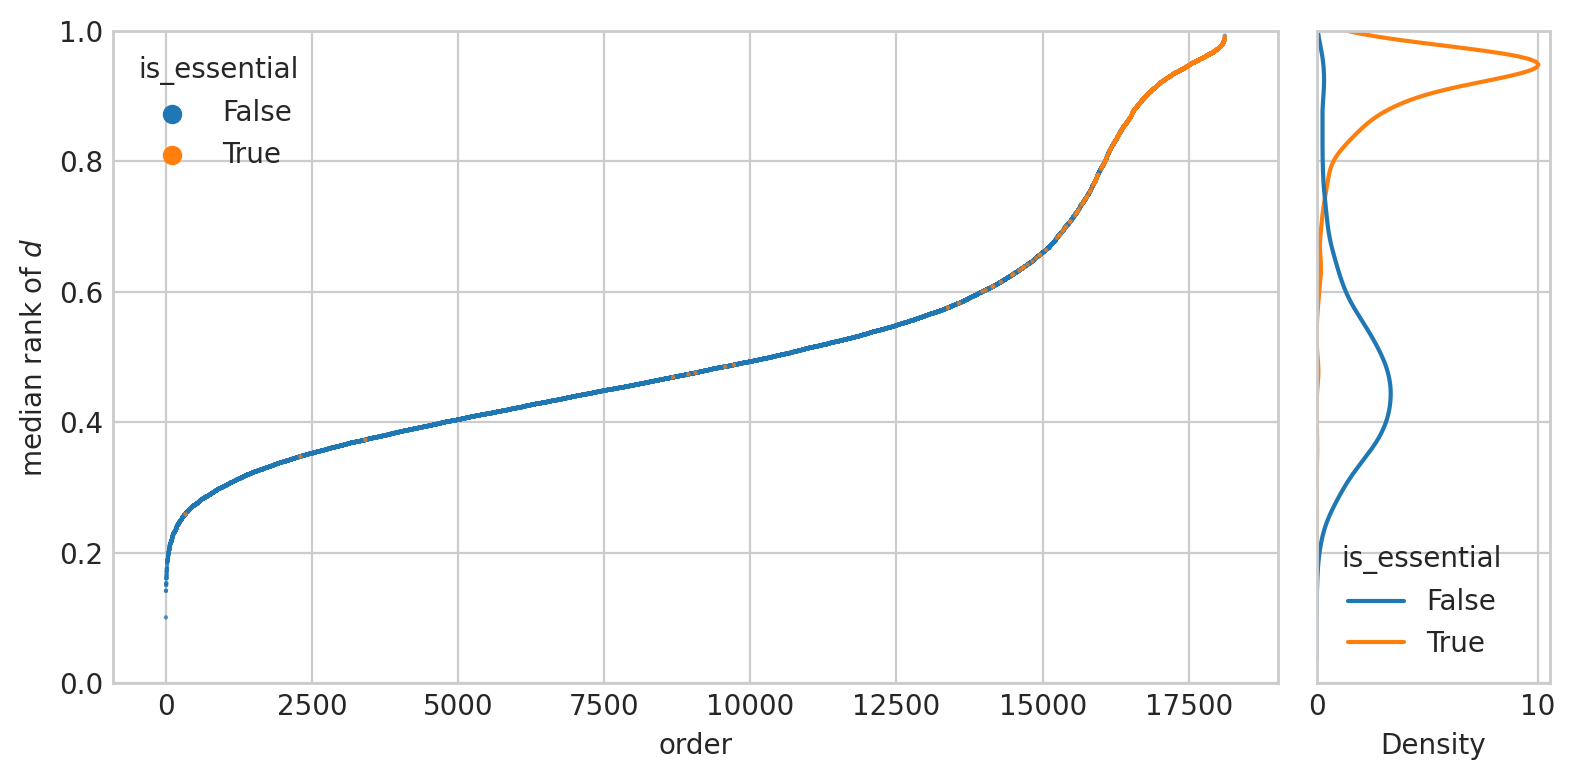

In [35]:
for v in ["b", "d"]:
    df = (
        total_ranked_genes.query(f"var_name == '{v}'")
        .sort_values("rank", ascending=True)
        .assign(order=lambda d: np.arange(len(d)))
        .sort_values("is_essential")
    )

    fig, axes = plt.subplots(
        ncols=2, figsize=(8, 4), sharey=True, gridspec_kw={"width_ratios": (5, 1)}
    )

    sns.scatterplot(
        data=df,
        x="order",
        y="rank",
        hue="is_essential",
        edgecolor=None,
        s=2,
        alpha=0.75,
        ax=axes[0],
    )
    sns.kdeplot(data=df, y="rank", hue="is_essential", common_norm=False, ax=axes[1])
    axes[0].set_ylabel(f"median rank of ${v}$")
    axes[0].set_ylim(0, 1)
    fig.tight_layout()
    plt.show()

In [36]:
cn_total_ranked_genes = total_ranked_genes.query(f"var_name == '{v}'").assign(
    is_essential=lambda d: d["hugo_symbol"].isin(essential_genes)
)

essentials_cutoff = np.quantile(
    cn_total_ranked_genes.query("is_essential")["rank"], 0.9
)
print(f"essential 90% cut-off: {essentials_cutoff:0.4f}")
new_essential_genes = cn_total_ranked_genes.query(
    f"not is_essential and rank > {essentials_cutoff}"
).reset_index(drop=True)
new_essential_genes

essential 90% cut-off: 0.9685


hugo_symbol var_name      rank  is_essential
0        RPS3A        d  0.992660         False
1         RPL6        d  0.988189         False
2        RBM8A        d  0.987251         False
3        RPL17        d  0.985761         False
4        RPL34        d  0.984602         False
5     ATP6V1B2        d  0.983664         False
6        HSPE1        d  0.983664         False
7        RPL14        d  0.982560         False
8        RPL23        d  0.981953         False
9        RPL7A        d  0.981677         False
10        RPS7        d  0.981677         False
11       ESPL1        d  0.981566         False
12       SF3B4        d  0.980297         False
13      RPS27A        d  0.980076         False
14       SRSF3        d  0.979800         False
15        RRN3        d  0.979745         False
16       RPL24        d  0.979524         False
17     SNRNP25        d  0.978310         False
18        RPL7        d  0.978034         False
19      EXOSC6        d  0.977317         False
20      SNRPD1        d  0.977041         False
21       SF3B5        d  0.976820         False
22       CIAO3        d  0.976544         False
23      SS18L2        d  0.975495         False
24         DUT        d  0.975440         False
25       RPS28        d  0.975275         False
26       PSMC2        d  0.974723         False
27      DPAGT1        d  0.974447         False
28        KRT8        d  0.974392         False
29       MAK16        d  0.974336         False
30        LSM8        d  0.974281         False
31        RPSA        d  0.974005         False
32       SNRPG        d  0.973840         False
33     CFAP298        d  0.973729         False
34     RSL24D1        d  0.973674         False
35       MED11        d  0.973343         False
36       PSMA6        d  0.973343         False
37       LETM1        d  0.972846         False
38       RPS19        d  0.972681         False
39       RPS24        d  0.972405         False
40       DHX37        d  0.972294         False
41        RPL5        d  0.971466         False
42      SNAPC5        d  0.971466         False
43       GTF3A        d  0.971246         False
44        LSM7        d  0.971025         False
45       PSMA4        d  0.970804         False
46       PHF5A        d  0.970694         False
47        LSM2        d  0.970528         False
48       CDCA8        d  0.970307         False
49     ATP6V1F        d  0.969700         False
50       CAPZB        d  0.969645         False
51       EIF3G        d  0.969535         False
52      SNRPA1        d  0.969535         False
53       RPS17        d  0.969314         False
54       CDC27        d  0.969204         False
55       PSMB3        d  0.968597         False
56        SBDS        d  0.968597         False

In [39]:
new_essentials_annotations = {
    "ATP6V1B2": "mitochondrial",
    "ANAPC2": "cell cycle",
    "ATP6V1F": "mitochondrial",
    "CAPZB": "cytoskeleton",
    "CDC27": "cell cycle",
    "CDCA8": "cell cycle",
    "CFAP298": "cilium",
    "CIAO3": "mitochondrial",
    "DHX37": "mitochondrial",
    "DPAGT1": "metabolism",
    "DUT": "mitochondrial",
    "EIF3G": "translation",
    "ESPL1": "cell cycle",
    "EXOSC6": "exosome",
    "GTF3A": "transcription",
    "HSPE1": "mitochondrial",
    "KRT8": "cytoskeleton",
    "LETM1": "mitochondrial",
    "LSM2": "splicing",
    "LSM7": "splicing",
    "LSM8": "splicing",
    "MAK16": "translation",
    "MED11": "transcription",
    "PHF5A": "transcription",
    "PSMA4": "proteasome",
    "PSMA6": "proteasome",
    "PSMB3": "proteasome",
    "PSMC2": "proteasome",
    "RBM8A": "splicing",
    "RPL14": "ribosomal",
    "RPL17": "ribosomal",
    "RPL23": "ribosomal",
    "RPL24": "ribosomal",
    "RPL34": "ribosomal",
    "RPL5": "ribosomal",
    "RPL6": "ribosomal",
    "RPL7": "ribosomal",
    "RPL7A": "ribosomal",
    "RPS17": "ribosomal",
    "RPS19": "ribosomal",
    "RPS24": "ribosomal",
    "RPS27A": "ribosomal",
    "RPS28": "ribosomal",
    "RPS3A": "ribosomal",
    "RPS7": "ribosomal",
    "RPSA": "ribosomal",
    "RRN3": "transcription",
    "RSL24D1": "ribosomal",
    "SBDS": "translation",
    "SF3B4": "splicing",
    "SF3B5": "splicing",
    "SNAPC5": "splicing",
    "SNRNP25": "splicing",
    "SNRPA1": "splicing",
    "SNRPD1": "splicing",
    "SNRPG": "splicing",
    "SRSF3": "splicing",
    "SS18L2": "transcription",
    "UTP4": "splicing",
}

labels = sorted(list(set(new_essentials_annotations.values())))
new_essentials_pal = dict(zip(labels, sns.color_palette("icefire", len(labels))))
new_essentials_pal["essential"] = "grey"

In [40]:
_new_ess_genes = list(new_essentials_annotations.keys())
missing_anno = new_essential_genes[
    ~new_essential_genes["hugo_symbol"].isin(_new_ess_genes)
]["hugo_symbol"]
assert len(missing_anno) == 0, missing_anno

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


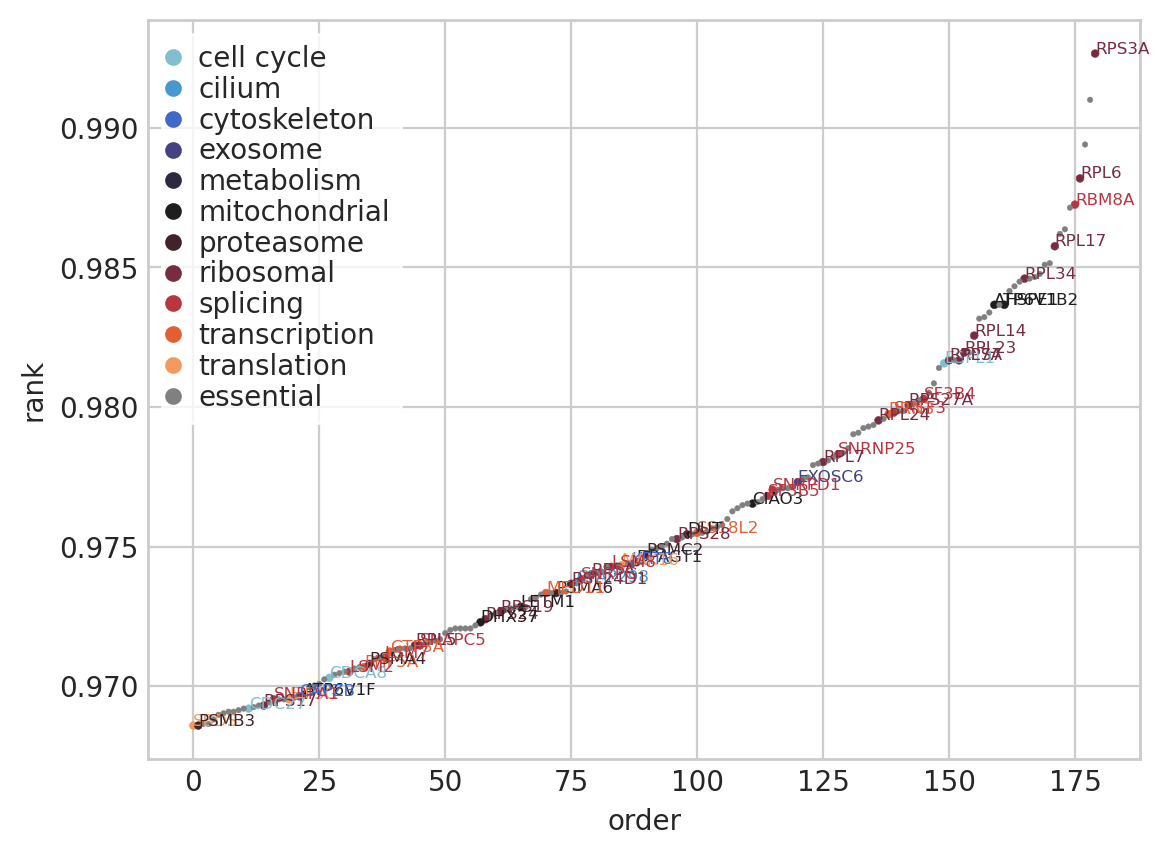

In [41]:
plot_df = (
    cn_total_ranked_genes.query(f"rank > {essentials_cutoff}")
    .reset_index(drop=True)
    .sort_values("rank", ascending=True)
    .assign(order=lambda d: np.arange(len(d)))
    .sort_values("is_essential")
    .assign(label=lambda d: d["hugo_symbol"].map(new_essentials_annotations))
    .fillna({"label": "essential"})
    .assign(
        label=lambda d: pd.Categorical(
            d["label"], categories=list(new_essentials_pal.keys()), ordered=True
        )
    )
    .reset_index(drop=True)
)

sizes = {True: 4, False: 8}

ax = sns.scatterplot(
    data=plot_df,
    x="order",
    y="rank",
    hue="label",
    size="is_essential",
    sizes=sizes,
    edgecolor=None,
    palette=new_essentials_pal,
    legend=False,
)

texts = []
for _, row in plot_df.iterrows():
    if not row["is_essential"]:
        txt = ax.text(
            row["order"],
            row["rank"],
            row["hugo_symbol"],
            size=6,
            color=new_essentials_pal[row["label"]],
        )
        texts.append(txt)
# adjust_text(texts, ax=ax, force_points=0, force_objects=0)

ax.legend(
    handles=pal_to_legend_handles(new_essentials_pal, lw=0, marker="o", markersize=5),
    loc="upper left",
    frameon=True,
    edgecolor="white",
    labelspacing=0.1,
    handletextpad=0.9,
    handlelength=0,
)
plt.show()

In [42]:
# Save components for figure.
plot_df.to_csv(OUTPUT_DIR / "new-essential-genes-plot-data.csv", index=False)
with open(OUTPUT_DIR / "new-essentials-pal.json", "w") as fp:
    json.dump(new_essentials_pal, fp)

In [43]:
def closest_distance_from_a_to_any_in_b(
    a: str, b: set[str], loc_df: pd.DataFrame
) -> float:
    chrom = loc_df[loc_df["hugo_symbol"] == a]["sgrna_target_chr"].values[0]
    others = loc_df.filter_column_isin("hugo_symbol", b).query(
        f"sgrna_target_chr == '{chrom}'"
    )
    if len(others) == 0:
        return np.nan
    loc = loc_df[loc_df["hugo_symbol"] == a]["sgrna_target_pos"].values[0]
    return np.min(np.abs(others["sgrna_target_pos"] - loc))

In [44]:
dist_to_essentials_stash_fp = STASH_DIR / "dist_to_essentials.csv"
if dist_to_essentials_stash_fp.exists():
    dist_to_essentials = pd.read_csv(dist_to_essentials_stash_fp)
else:
    _dist_to_essentials = []
    for g in gene_chr_map["hugo_symbol"]:
        d = closest_distance_from_a_to_any_in_b(g, essential_genes, gene_chr_map)
        _dist_to_essentials.append((g, d))

    dist_to_essentials = pd.DataFrame(
        _dist_to_essentials, columns=["hugo_symbol", "dist"]
    )
    dist_to_essentials.to_csv(dist_to_essentials_stash_fp, index=False)
dist_to_essentials.head()

hugo_symbol       dist
0        A1BG   200838.5
1        A1CF  7545767.5
2         A2M  2246746.0
3       A2ML1  1978099.0
4     A3GALT2   501977.5

<AxesSubplot:xlabel='dist', ylabel='Density'>

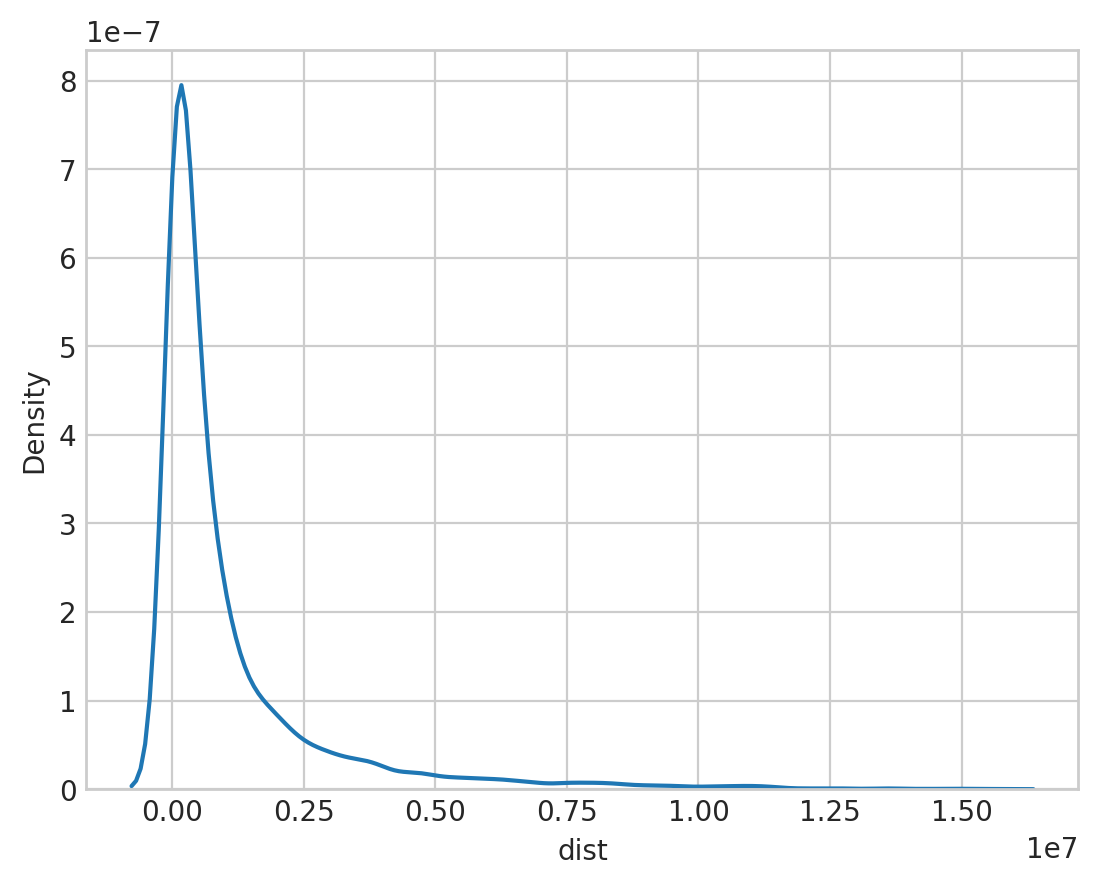

In [45]:
sns.kdeplot(dist_to_essentials["dist"])

In [46]:
lbls = []
for g in dist_to_essentials["hugo_symbol"]:
    if g in essential_genes:
        lbls.append("essential")
    elif g in set(new_essential_genes["hugo_symbol"]):
        lbls.append("new essential")
    else:
        lbls.append("other")

dist_to_essentials["gene_label"] = lbls

Do not seem to be closer to other essential genes than the other genes.

<AxesSubplot:xlabel='gene_label', ylabel='log_dist'>

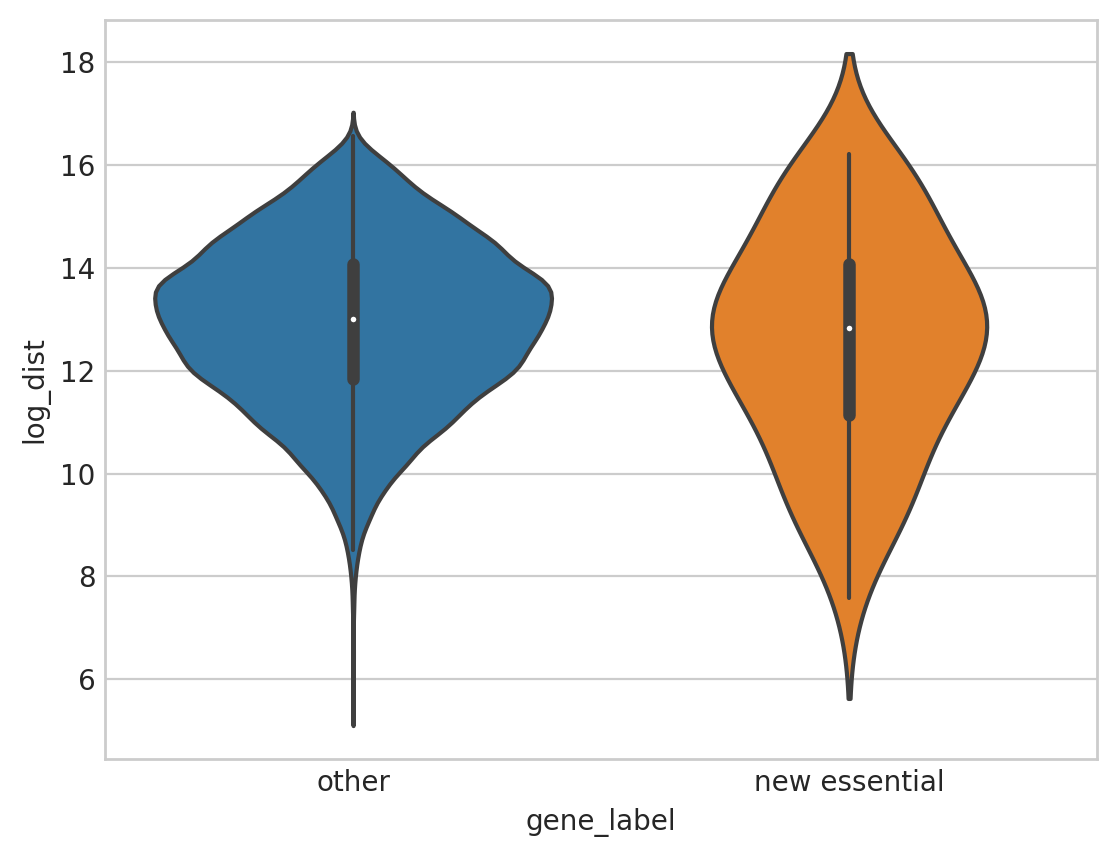

In [47]:
plt_df = dist_to_essentials.filter_column_isin(
    "hugo_symbol", essential_genes, complement=True
).assign(log_dist=lambda d: np.log(d["dist"]))
sns.violinplot(data=plt_df, x="gene_label", y="log_dist")

<AxesSubplot:xlabel='sgrna_target_pos', ylabel='mean'>

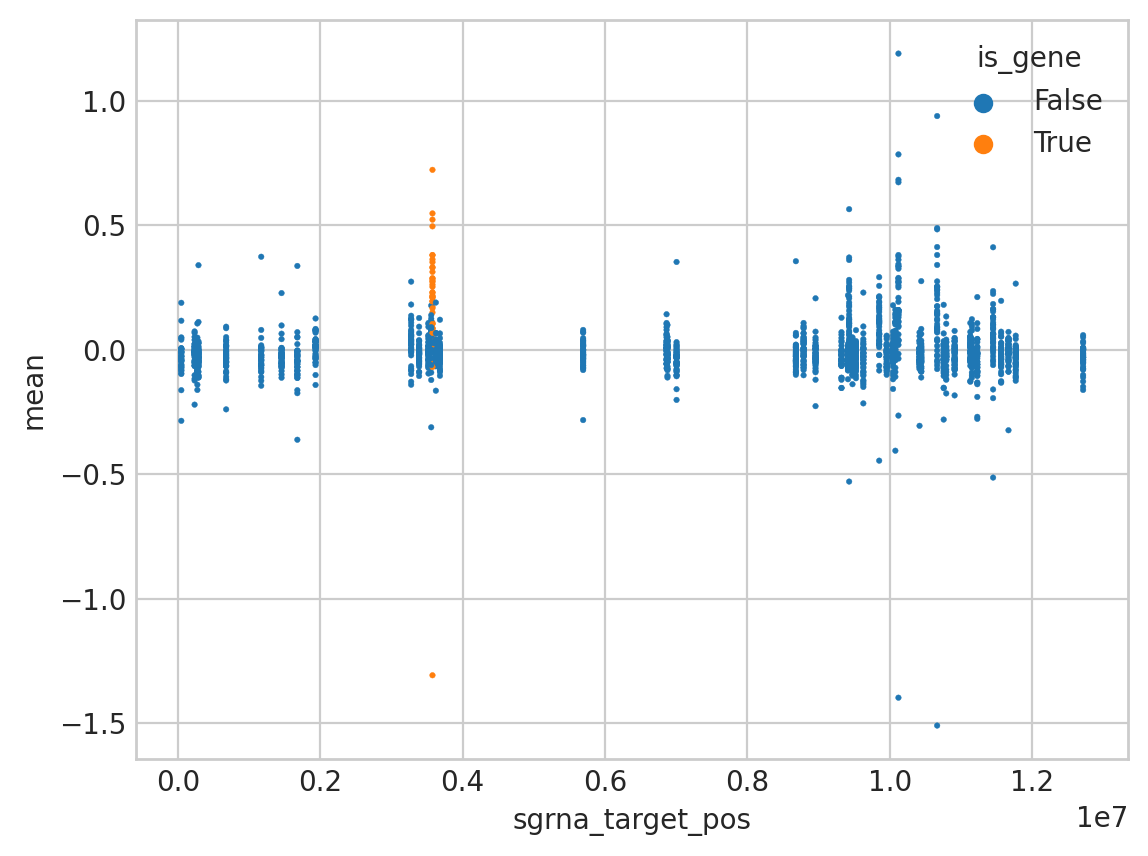

In [48]:
G = "RPS7"
gene_info = gene_chr_map.query(f"hugo_symbol == '{G}'")
gene_chr = gene_info["sgrna_target_chr"].values[0]
gene_loc = gene_info["sgrna_target_pos"].values[0]
dx = 1.0e7

neighbors = (
    gene_chr_map.query(f"sgrna_target_chr == '{gene_chr}'")
    .query(f"{gene_loc - dx} < sgrna_target_pos")
    .query(f"sgrna_target_pos < {gene_loc + dx}")
)

neighbors_cn_post = (
    rna_cn_posterior.query("var_name == 'd'")
    .filter_column_isin("hugo_symbol", neighbors["hugo_symbol"])
    .assign(is_gene=lambda d: d["hugo_symbol"] == G)
)

sns.scatterplot(
    data=neighbors_cn_post,
    x="sgrna_target_pos",
    y="mean",
    hue="is_gene",
    edgecolor=None,
    s=4,
)

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


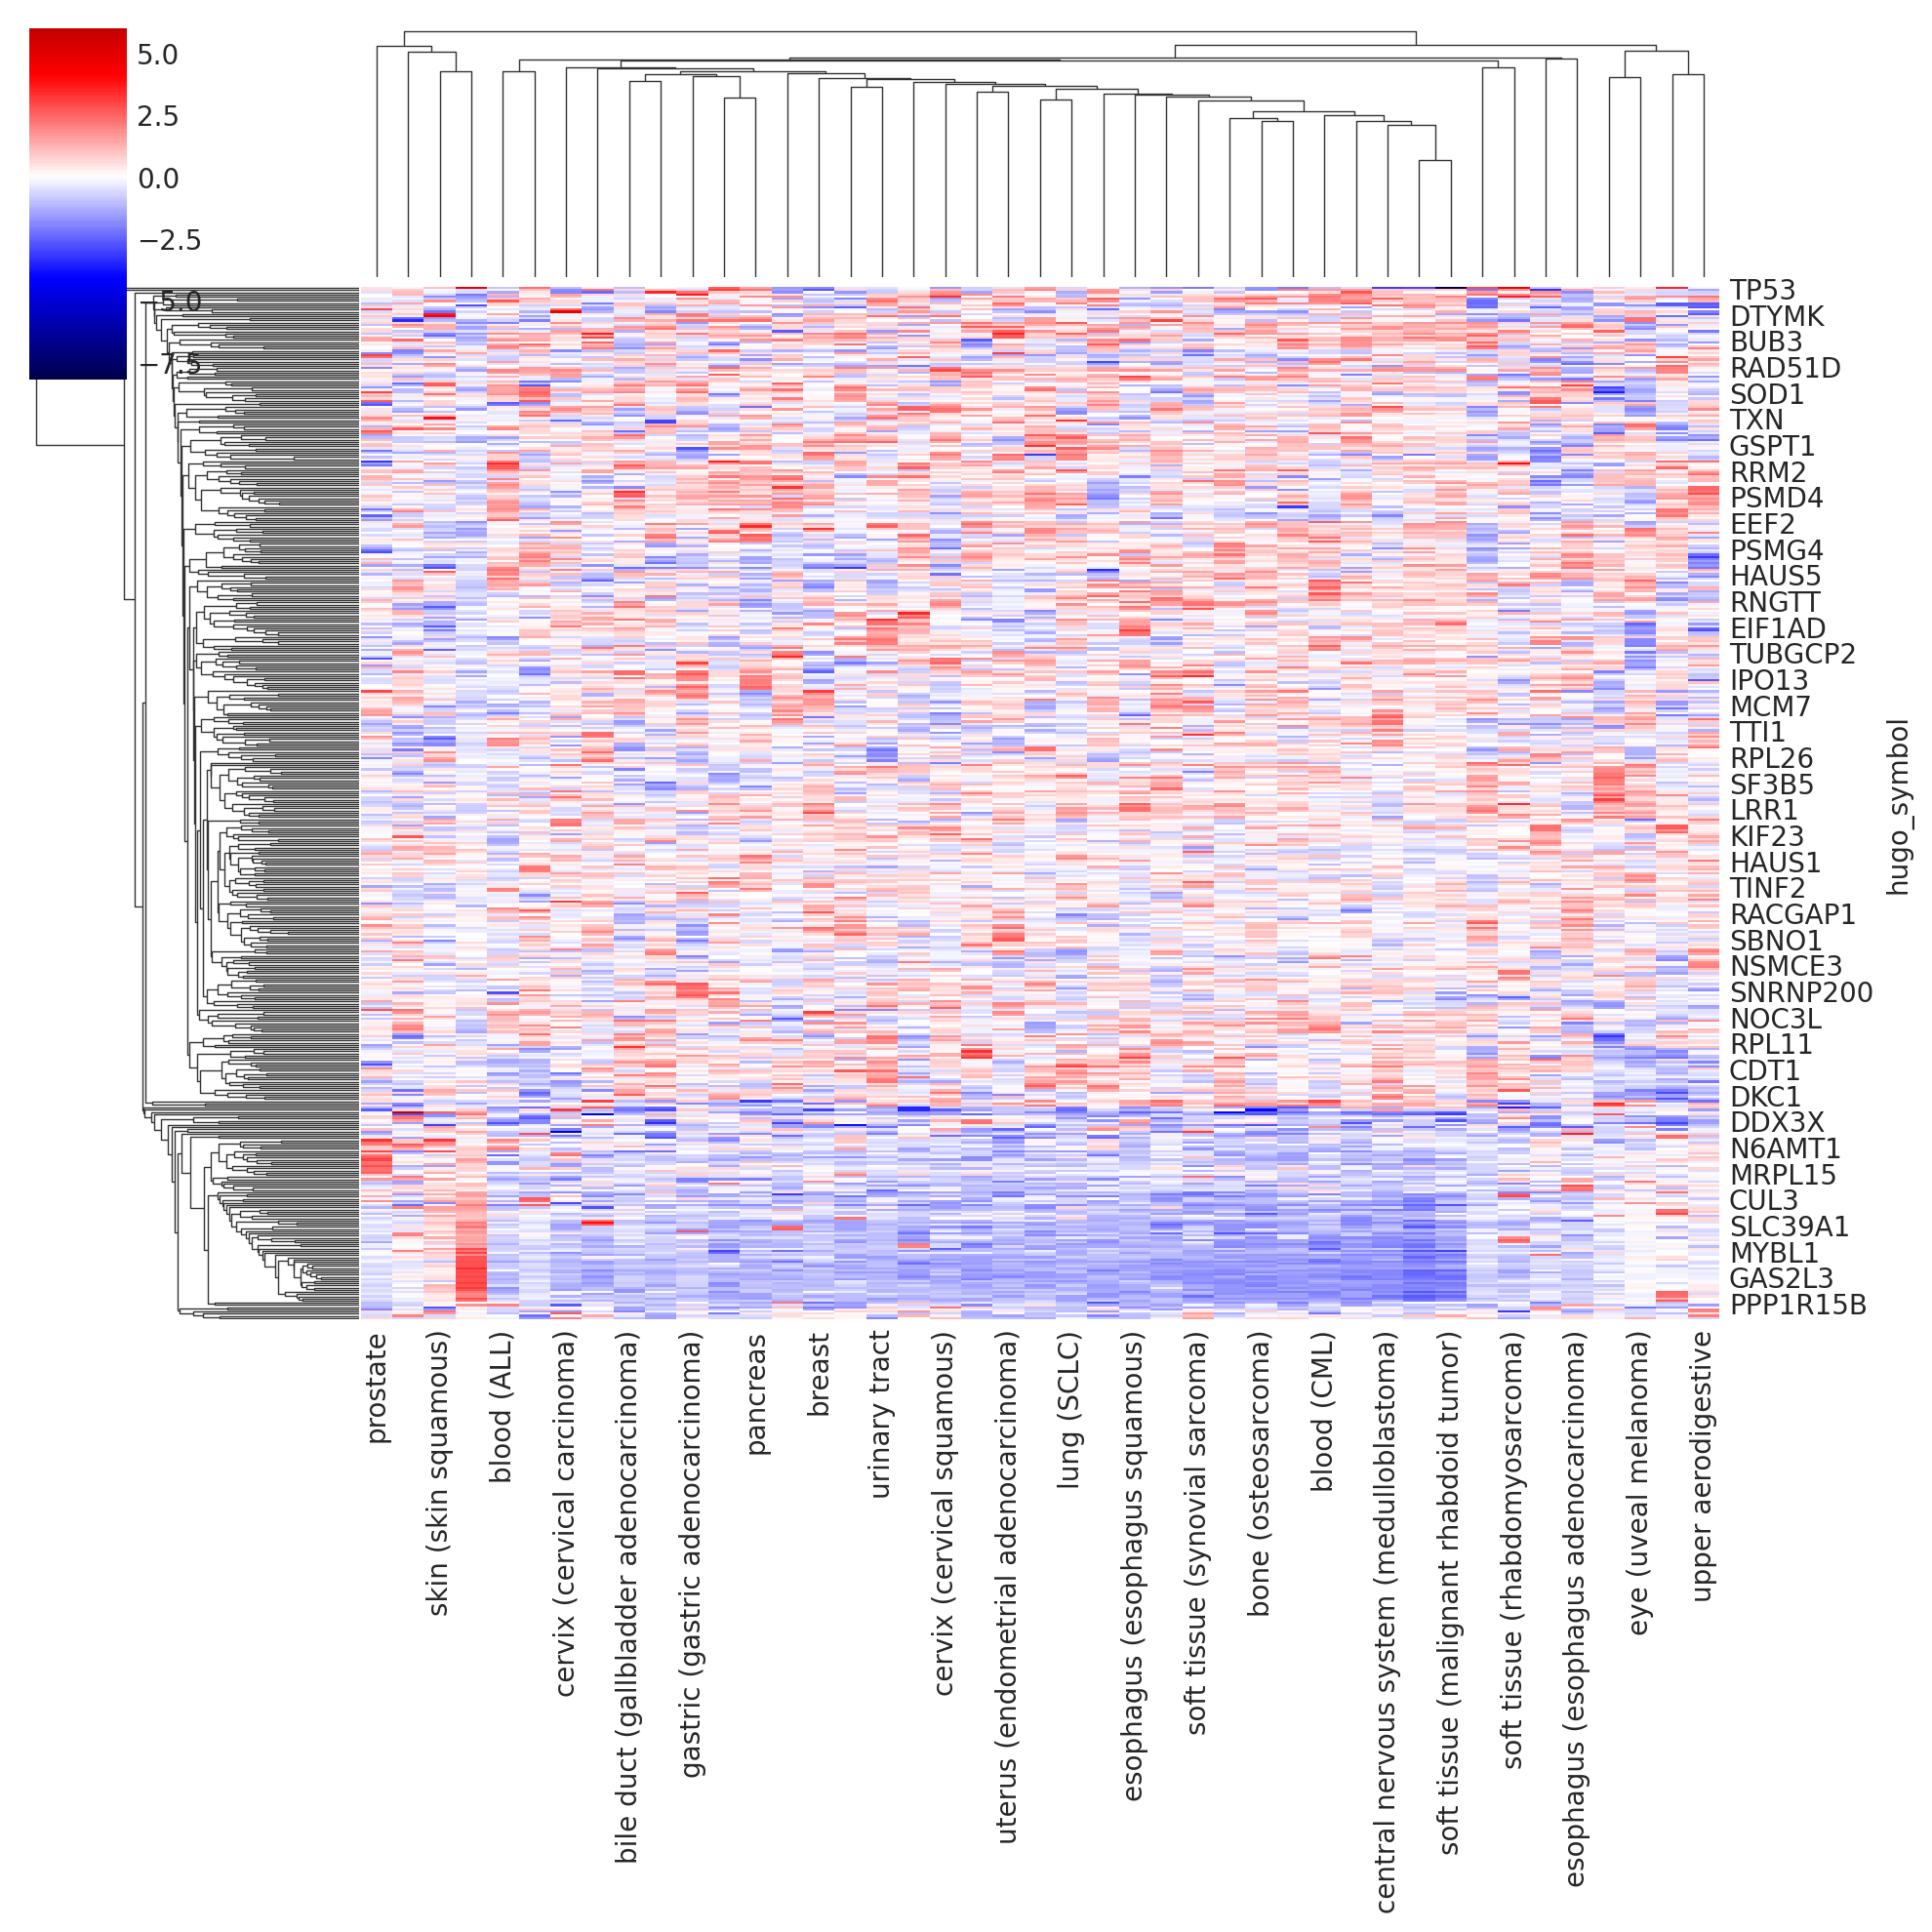

In [49]:
top_genes_per_subtype = (
    ranked_genes.sort_values(["lineage_subtype", "mean"], ascending=(True, False))
    .groupby("lineage_subtype")
    .head(20)
)

X = (
    rna_cn_posterior.query("var_name == 'd'")
    .filter_column_isin("hugo_symbol", top_genes_per_subtype["hugo_symbol"])
    .pivot_wider(["hugo_symbol"], names_from="lineage_subtype", values_from="mean")
    .set_index("hugo_symbol")
)

sns.clustermap(X, z_score=1, cmap="seismic", center=0)

variable: 'b'


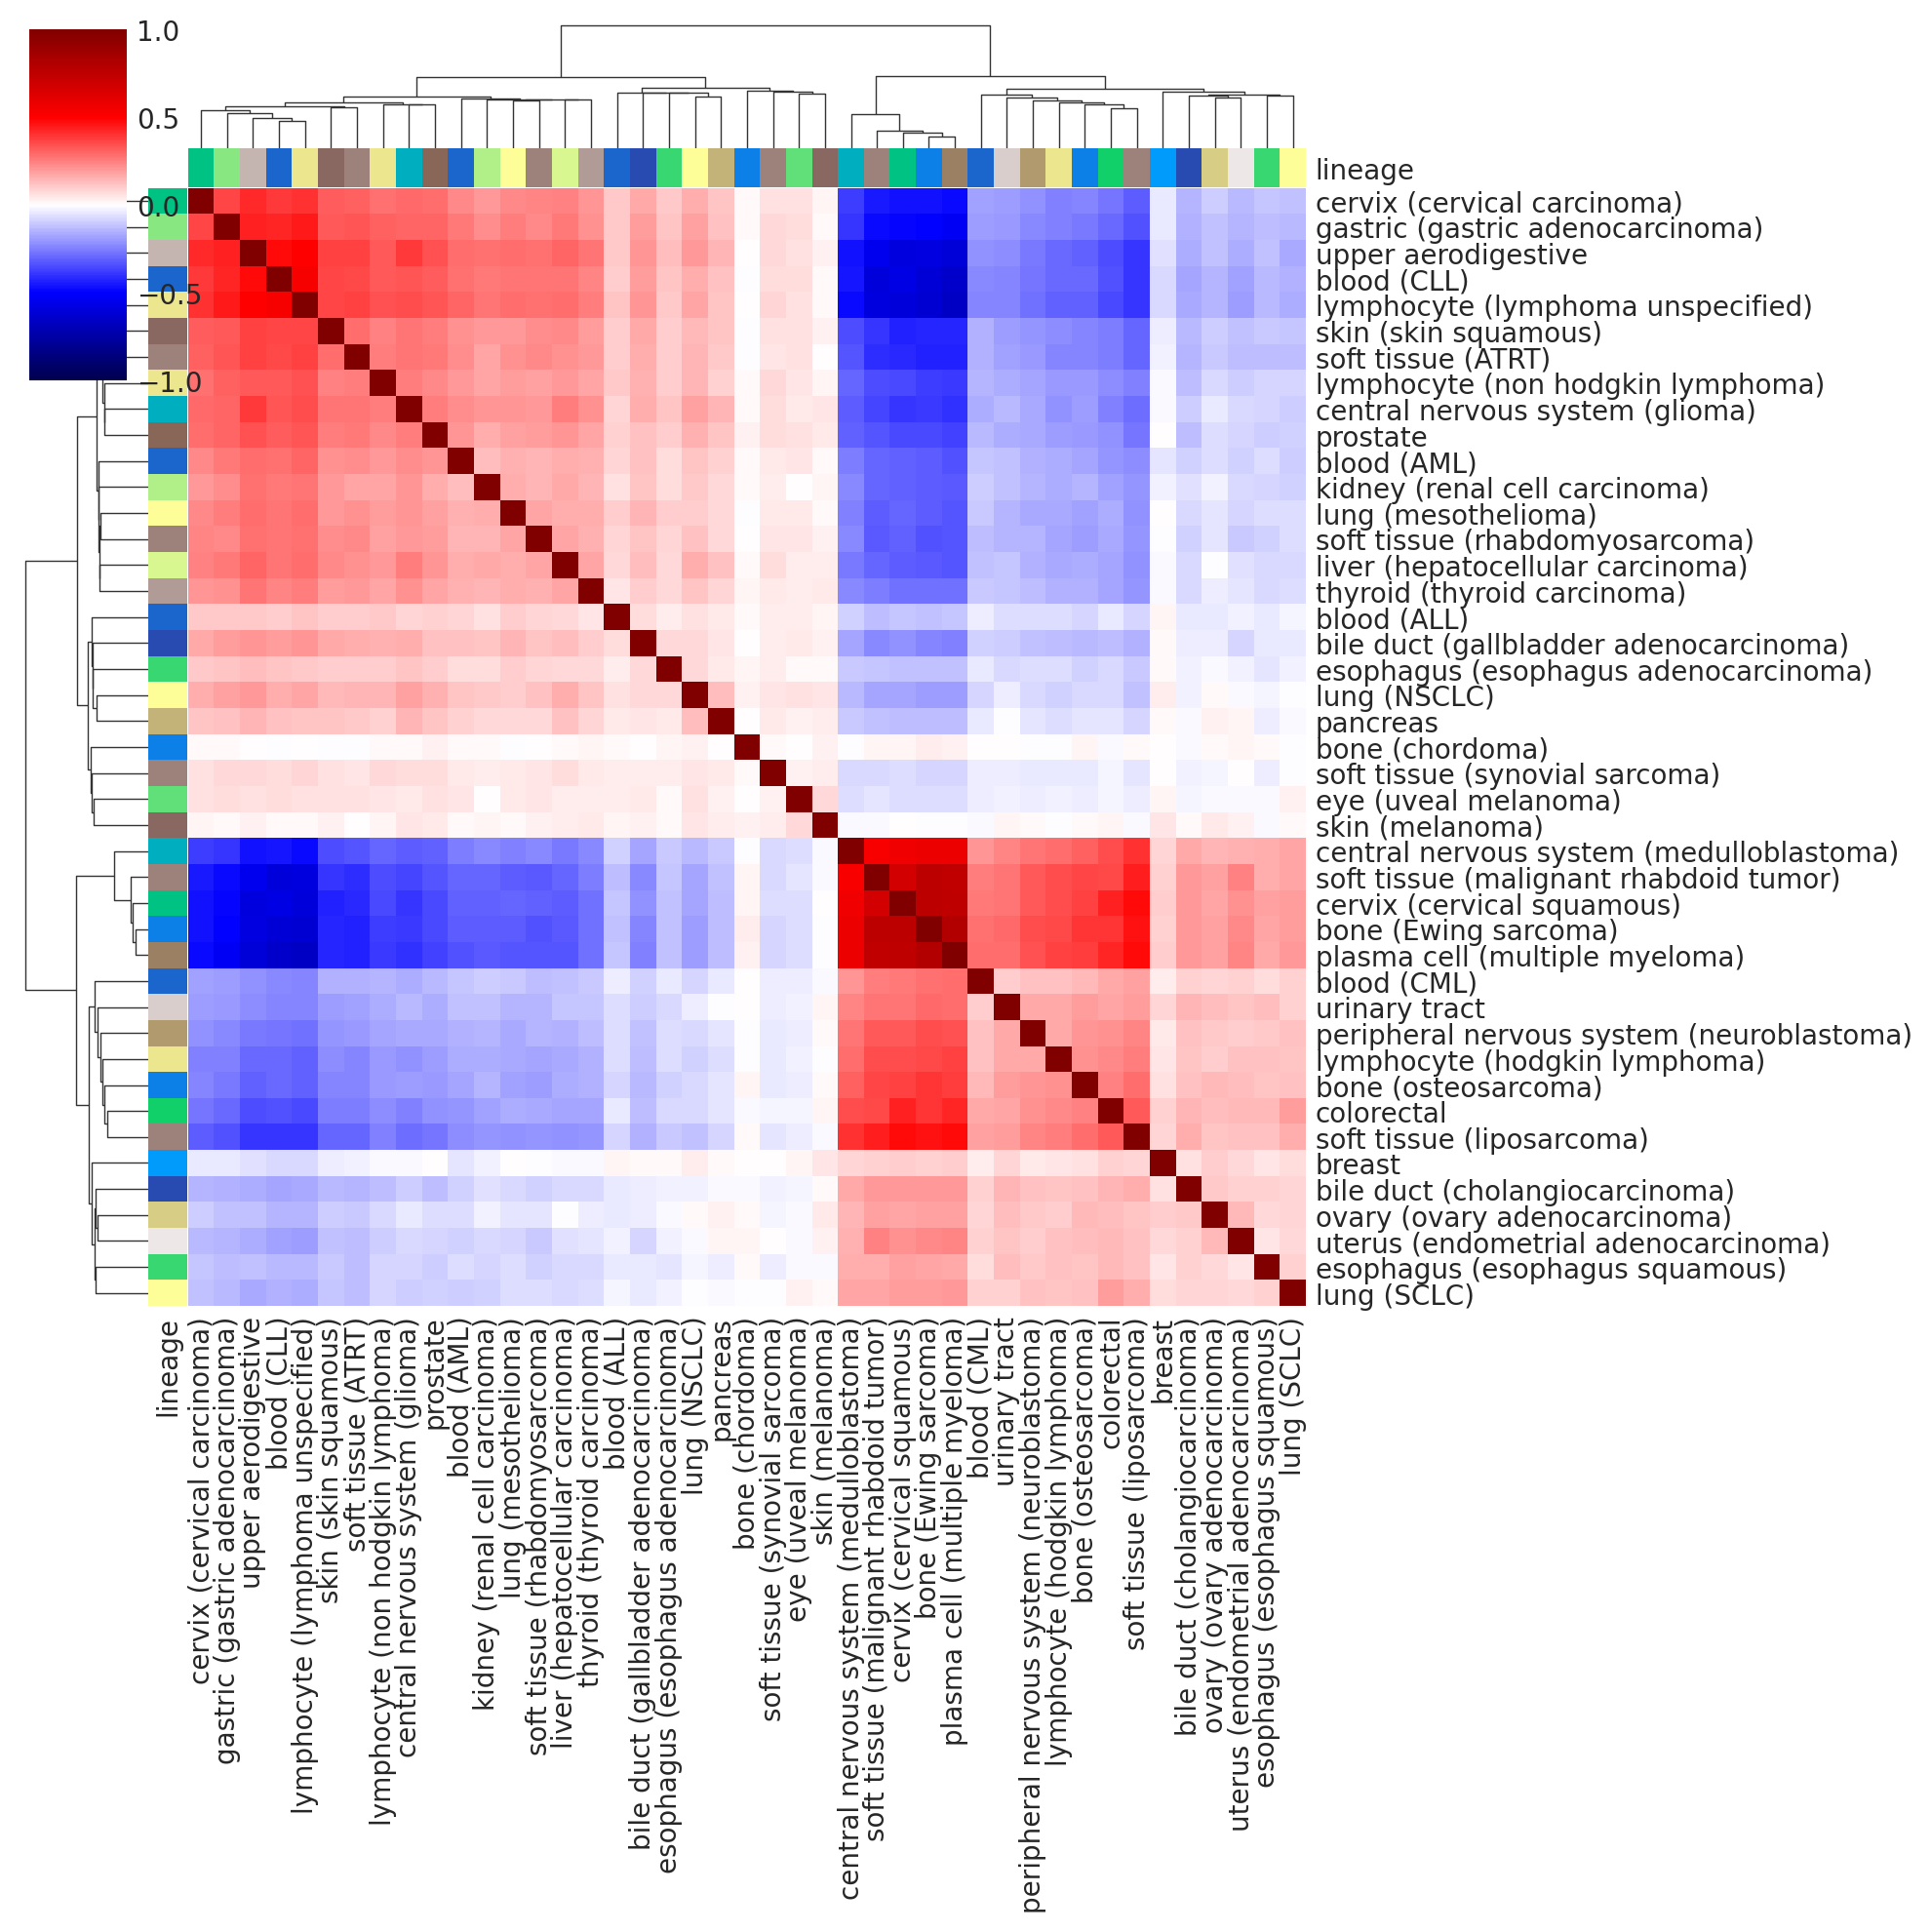

variable: 'd'


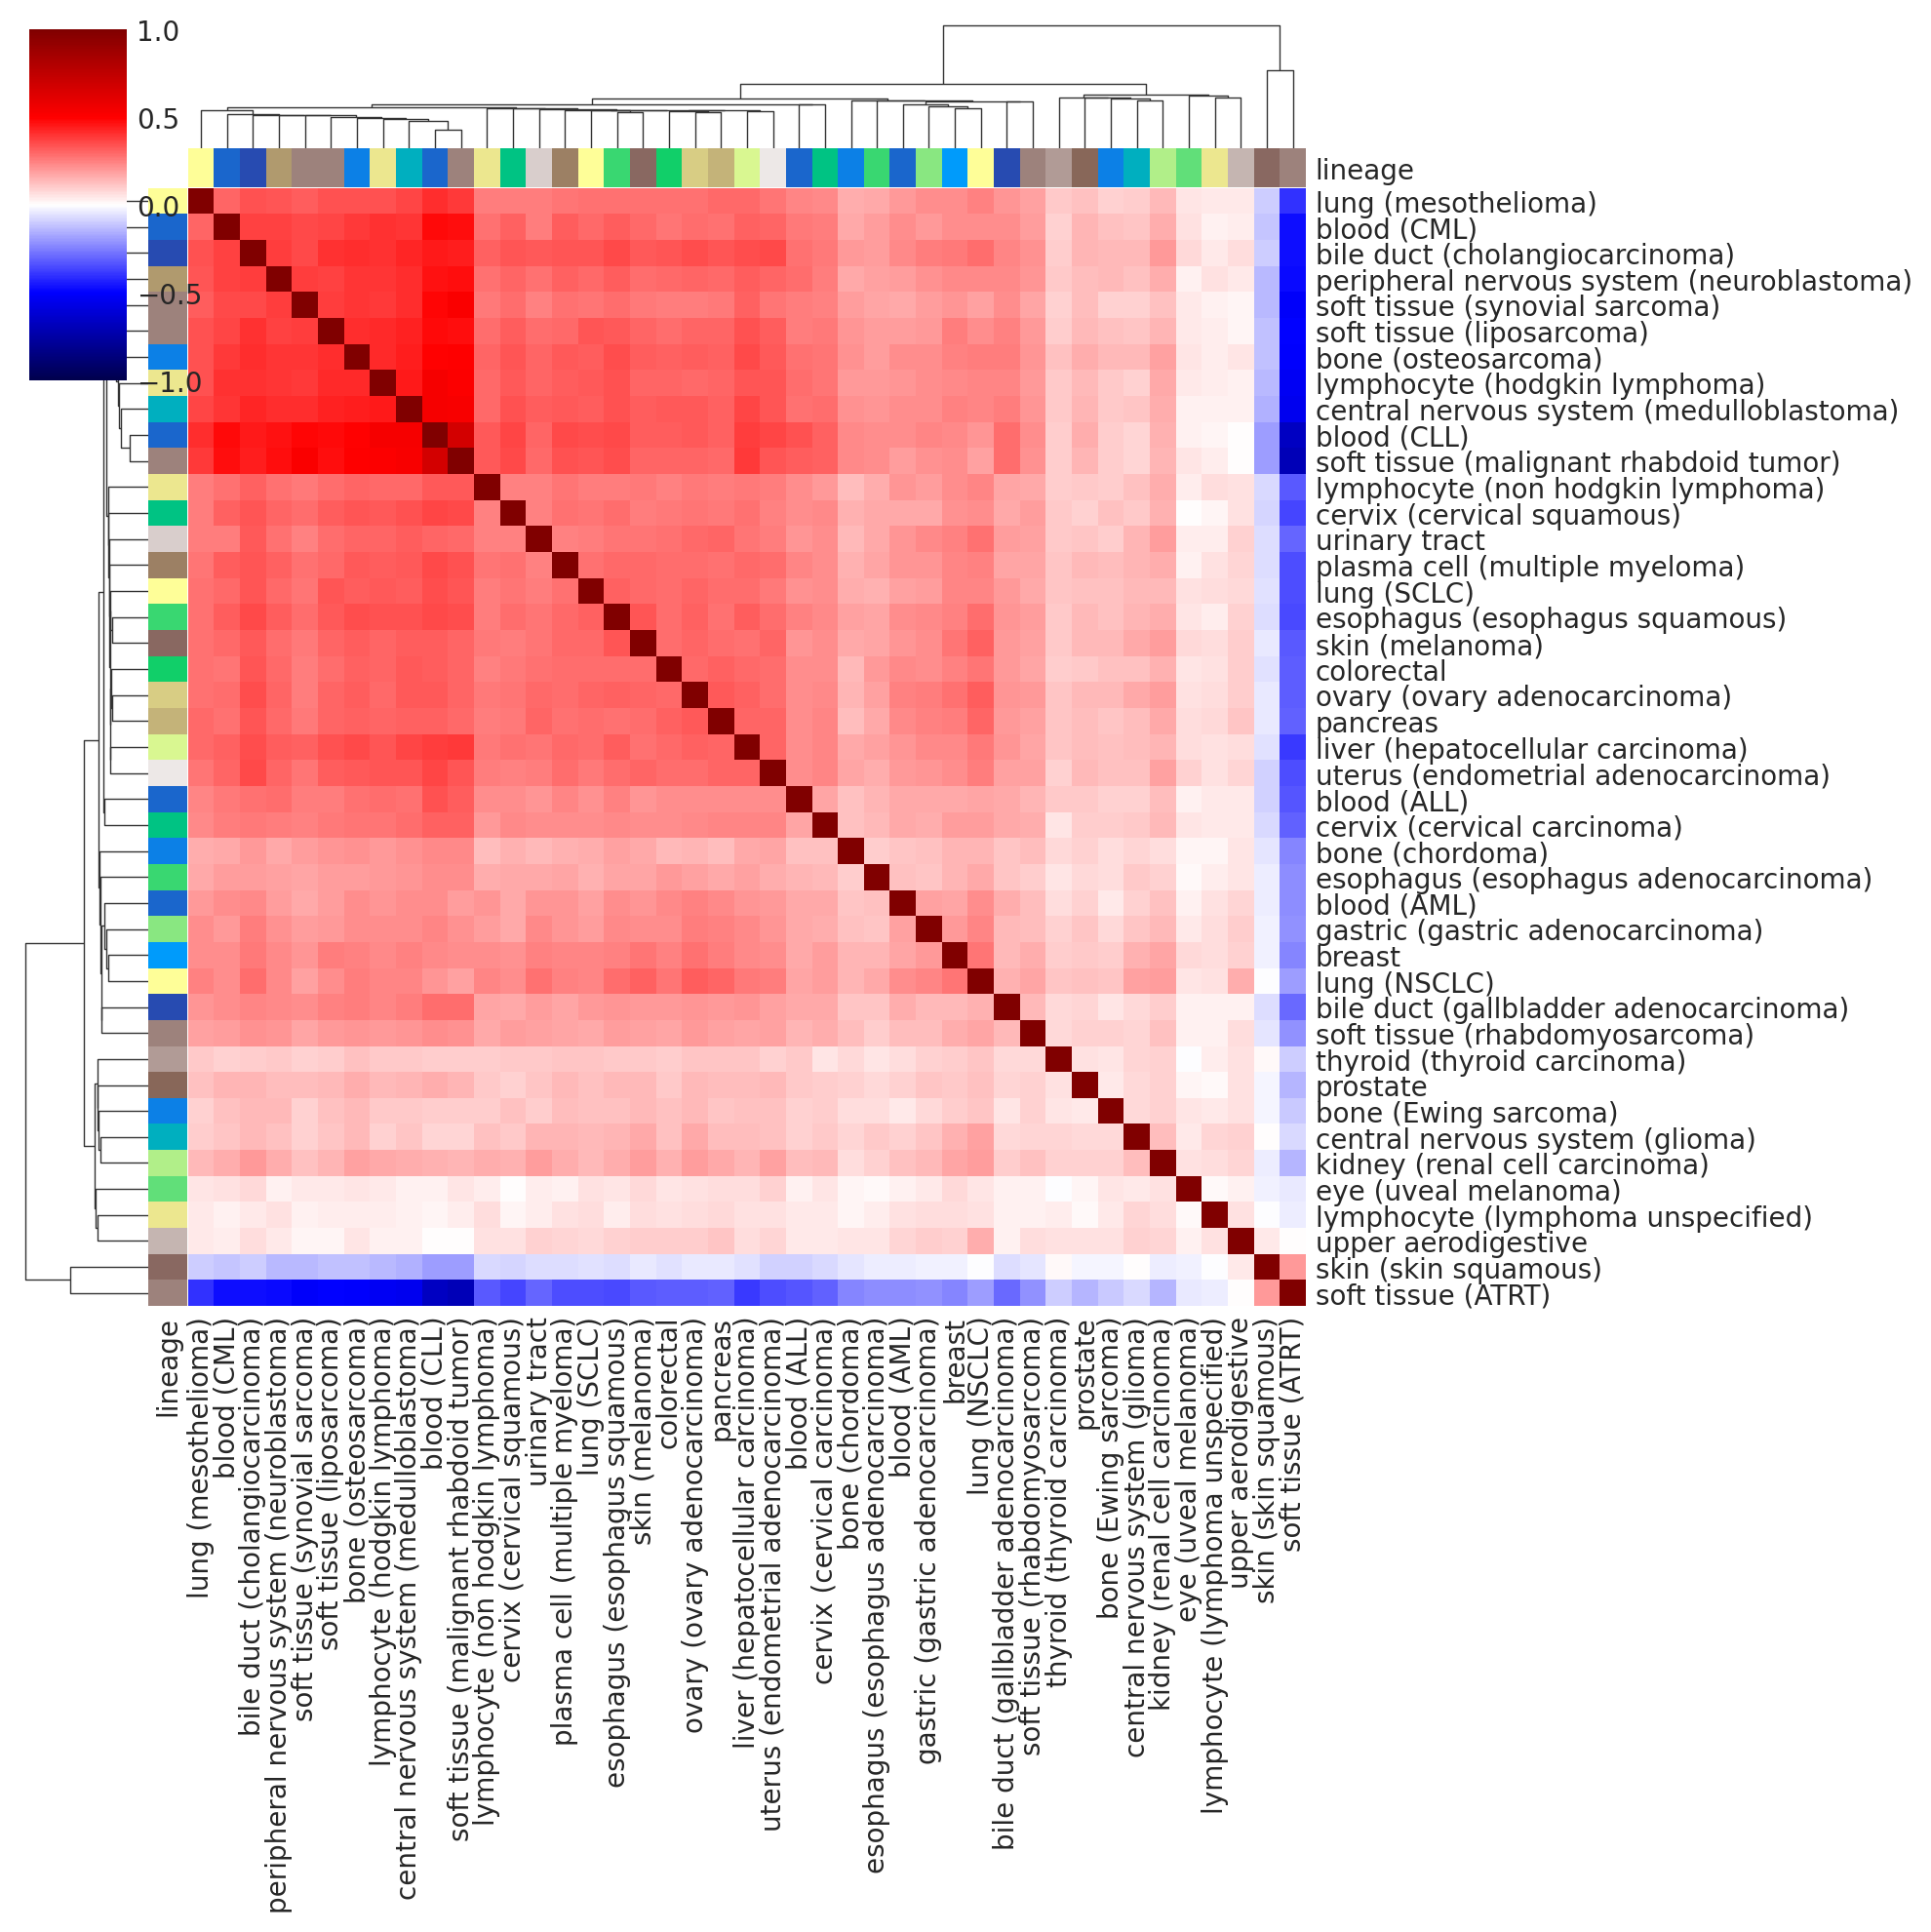

In [50]:
for v in ["b", "d"]:
    print(f"variable: '{v}'")
    X = (
        rna_cn_posterior.query(f"var_name == '{v}'")
        .reset_index(drop=True)
        .pivot_wider(["hugo_symbol"], names_from="lineage_subtype", values_from="mean")
        .corr(method="spearman")
    )

    colors = (
        pd.DataFrame({"lineage_subtype": X.index.tolist()})
        .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
        .assign(lineage=lambda d: d["lineage"].map(lineage_pal))
        .set_index("lineage_subtype")
    )

    sns.clustermap(
        X,
        figsize=(10, 10),
        dendrogram_ratio=(0.1, 0.1),
        xticklabels=1,
        yticklabels=1,
        cmap="seismic",
        row_colors=colors,
        col_colors=colors,
        center=0,
        vmin=-1,
        vmax=1,
    )
    plt.show()

### Cell lines

In [51]:
cell_effects = (
    pd.concat(
        [
            get_variables_posterior_summary(pm, var_names=["mu_k", "mu_m"])
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, col="parameter", names="depmap_id")
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
)
cell_effects.head(3)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  mu_k[ACH-000182] -0.025  0.023    -0.059      0.013      0.001    0.001   
1  mu_k[ACH-000209]  0.054  0.022     0.021      0.091      0.001    0.001   
2  mu_k[ACH-000377] -0.053  0.022    -0.087     -0.018      0.001    0.001   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0     437.0     901.0   1.01     mu_k  bile duct (cholangiocarcinoma)   
1     456.0    1077.0   1.01     mu_k  bile duct (cholangiocarcinoma)   
2     488.0     885.0   1.01     mu_k  bile duct (cholangiocarcinoma)   

    depmap_id    lineage  
0  ACH-000182  bile duct  
1  ACH-000209  bile duct  
2  ACH-000377  bile duct

In [52]:
chrom_effects = (
    pd.concat(
        [
            get_variables_posterior_summary(pm, var_names=["k", "m"])
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, col="parameter", names="cell_chrom")
    .assign(
        depmap_id=lambda d: [c.split("__")[0] for c in d["cell_chrom"]],
        sgrna_target_chr=lambda d: [c.split("__")[1] for c in d["cell_chrom"]],
    )
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
)
chrom_effects.head(3)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  k[ACH-000182__1]  0.056  0.021     0.022      0.088      0.001    0.001   
1  k[ACH-000182__2] -0.046  0.021    -0.080     -0.012      0.001    0.001   
2  k[ACH-000182__3] -0.027  0.022    -0.062      0.007      0.001    0.001   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0     401.0     821.0   1.01        k  bile duct (cholangiocarcinoma)   
1     465.0    1048.0   1.01        k  bile duct (cholangiocarcinoma)   
2     493.0    1123.0   1.01        k  bile duct (cholangiocarcinoma)   

      cell_chrom   depmap_id sgrna_target_chr    lineage  
0  ACH-000182__1  ACH-000182                1  bile duct  
1  ACH-000182__2  ACH-000182                2  bile duct  
2  ACH-000182__3  ACH-000182                3  bile duct

In [53]:
cell_effects.to_csv(OUTPUT_DIR / "cell-effects.csv", index=False)
chrom_effects.to_csv(OUTPUT_DIR / "chromosome-effects.csv", index=False)

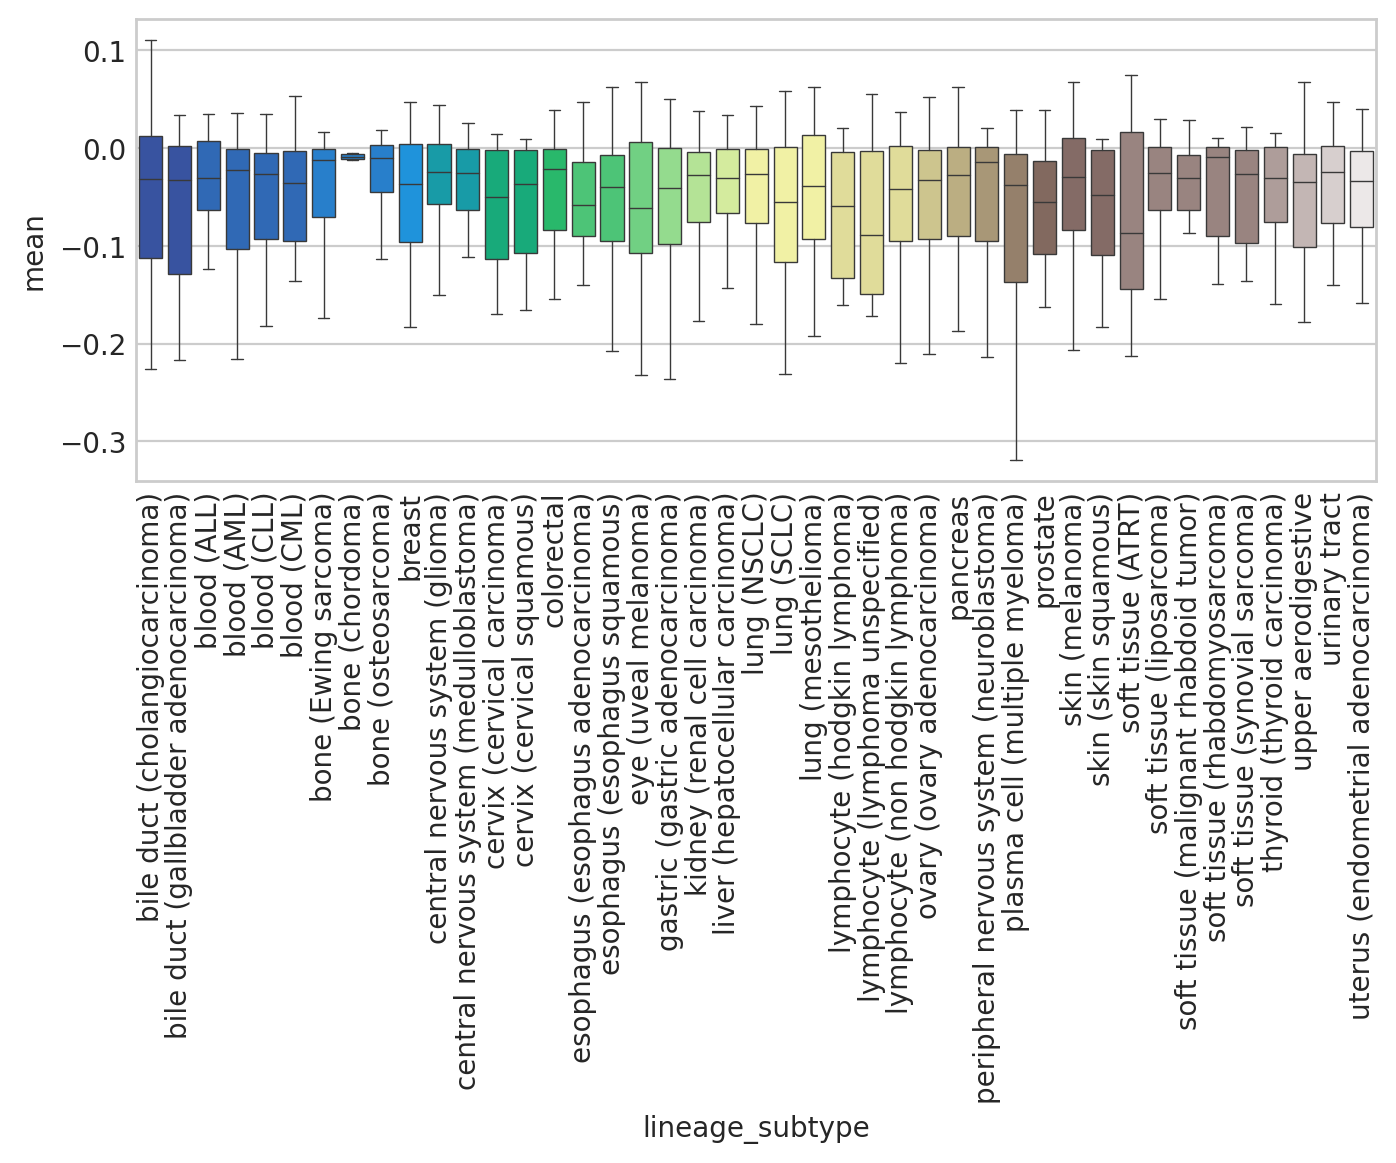

In [54]:
_, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(
    data=cell_effects,
    x="lineage_subtype",
    y="mean",
    hue="lineage",
    palette=lineage_pal,
    dodge=False,
    ax=ax,
    showfliers=False,
    linewidth=0.5,
)
ax.get_legend().remove()
ax.tick_params("x", rotation=90)
plt.show()

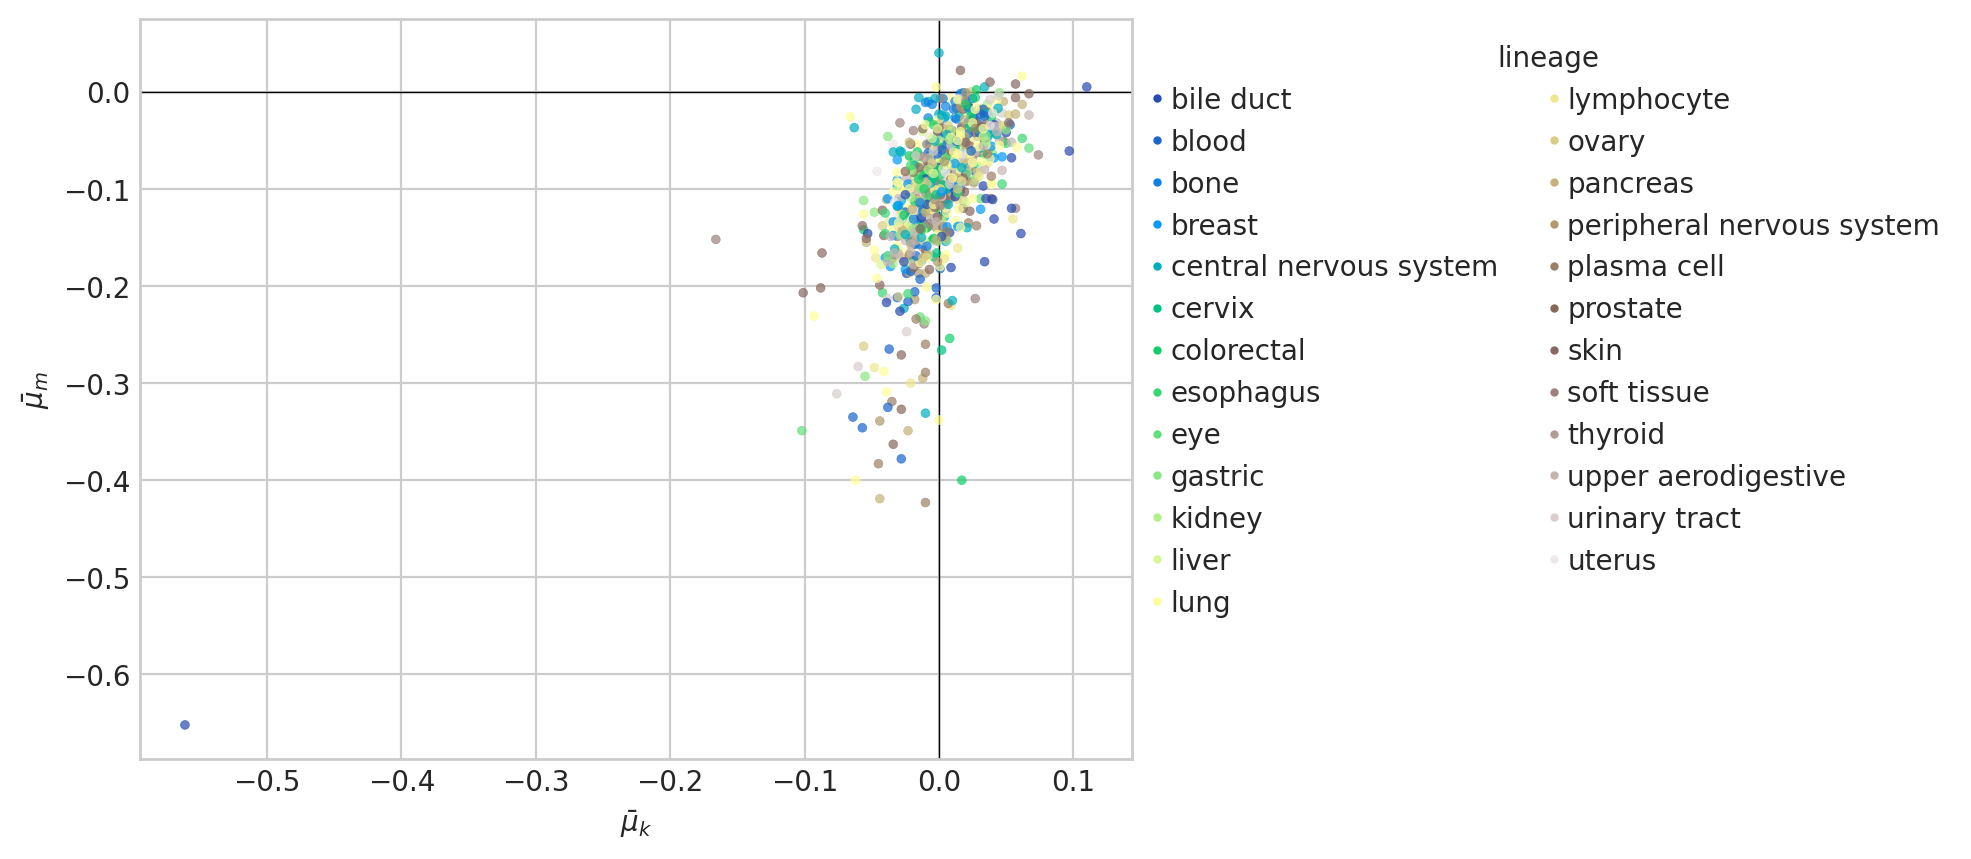

In [55]:
cell_effects_wide = cell_effects.pivot_wider(
    ["depmap_id", "lineage", "lineage_subtype"],
    names_from="var_name",
    values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
)

ax = sns.scatterplot(
    data=cell_effects_wide.sample(frac=1, random_state=12),
    x="mean_mu_k",
    y="mean_mu_m",
    hue="lineage",
    palette=lineage_pal,
    edgecolor=None,
    s=10,
    alpha=0.7,
    legend=False,
    zorder=10,
)
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)
ax.legend(
    handles=pal_to_legend_handles(lineage_pal, lw=0, marker="o", markersize=2),
    title="lineage",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handlelength=0,
    handletextpad=0.5,
    ncol=2,
)
ax.set_xlabel(r"$\bar{\mu}_k$")
ax.set_ylabel(r"$\bar{\mu}_m$")
plt.show()

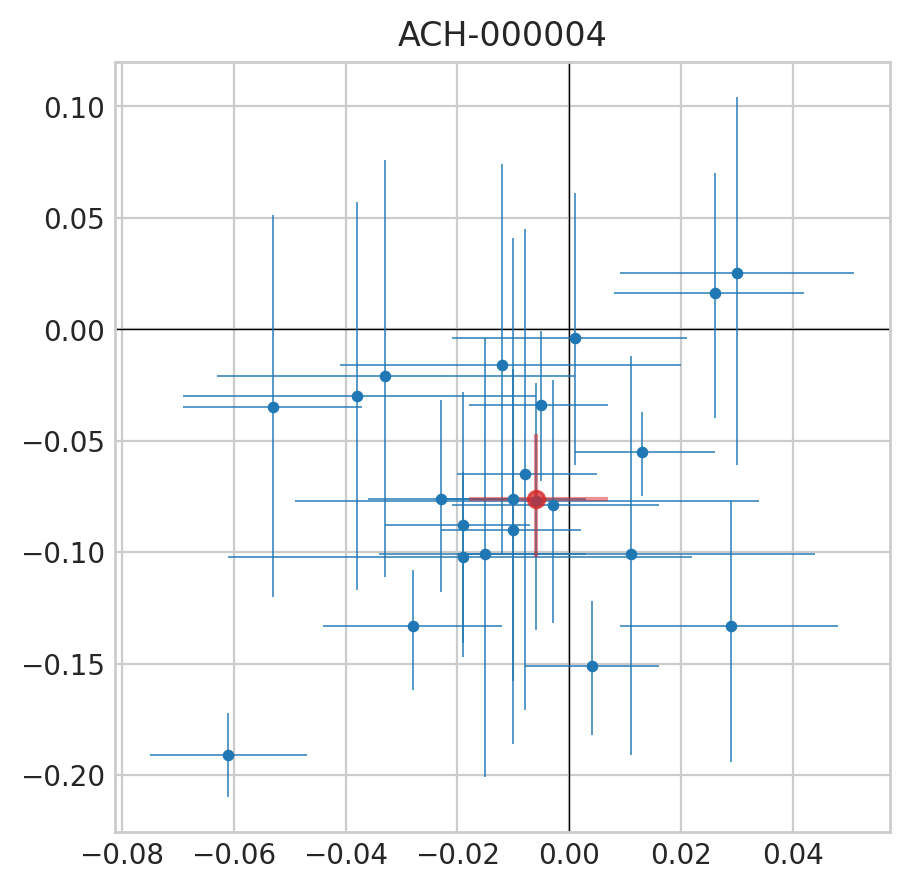

In [56]:
CELLLINE = cell_effects_wide["depmap_id"].unique()[0]

cell_line_avgs = cell_effects_wide.query(f"depmap_id == '{CELLLINE}'")

chrom_effects_wide = chrom_effects.query(f"depmap_id == '{CELLLINE}'").pivot_wider(
    ["sgrna_target_chr"],
    names_from="var_name",
    values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
)

_, ax = plt.subplots(figsize=(5, 5))
ax.set_title(CELLLINE)
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)

x = chrom_effects_wide["mean_k"]
y = chrom_effects_wide["mean_m"]
lines_kwargs = {"lw": 0.7, "alpha": 0.75, "color": "tab:blue"}
ax.vlines(
    x=x,
    ymin=chrom_effects_wide["hdi_5.5%_m"],
    ymax=chrom_effects_wide["hdi_94.5%_m"],
    **lines_kwargs,
    zorder=1,
)
ax.hlines(
    y=y,
    xmin=chrom_effects_wide["hdi_5.5%_k"],
    xmax=chrom_effects_wide["hdi_94.5%_k"],
    **lines_kwargs,
    zorder=1,
)

ax.scatter(
    x=cell_line_avgs["mean_mu_k"],
    y=cell_line_avgs["mean_mu_m"],
    c="tab:red",
    zorder=20,
    alpha=0.75,
)

lines_kwargs = {"lw": 1.5, "alpha": 0.5, "color": "tab:red"}
ax.vlines(
    x=cell_line_avgs["mean_mu_k"],
    ymin=cell_line_avgs["hdi_5.5%_mu_m"],
    ymax=cell_line_avgs["hdi_94.5%_mu_m"],
    **lines_kwargs,
    zorder=1,
)
ax.hlines(
    y=cell_line_avgs["mean_mu_m"],
    xmin=cell_line_avgs["hdi_5.5%_mu_k"],
    xmax=cell_line_avgs["hdi_94.5%_mu_k"],
    **lines_kwargs,
    zorder=1,
)

ax.scatter(x, y, s=10, zorder=10)
plt.show()

variable: 'k'


/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


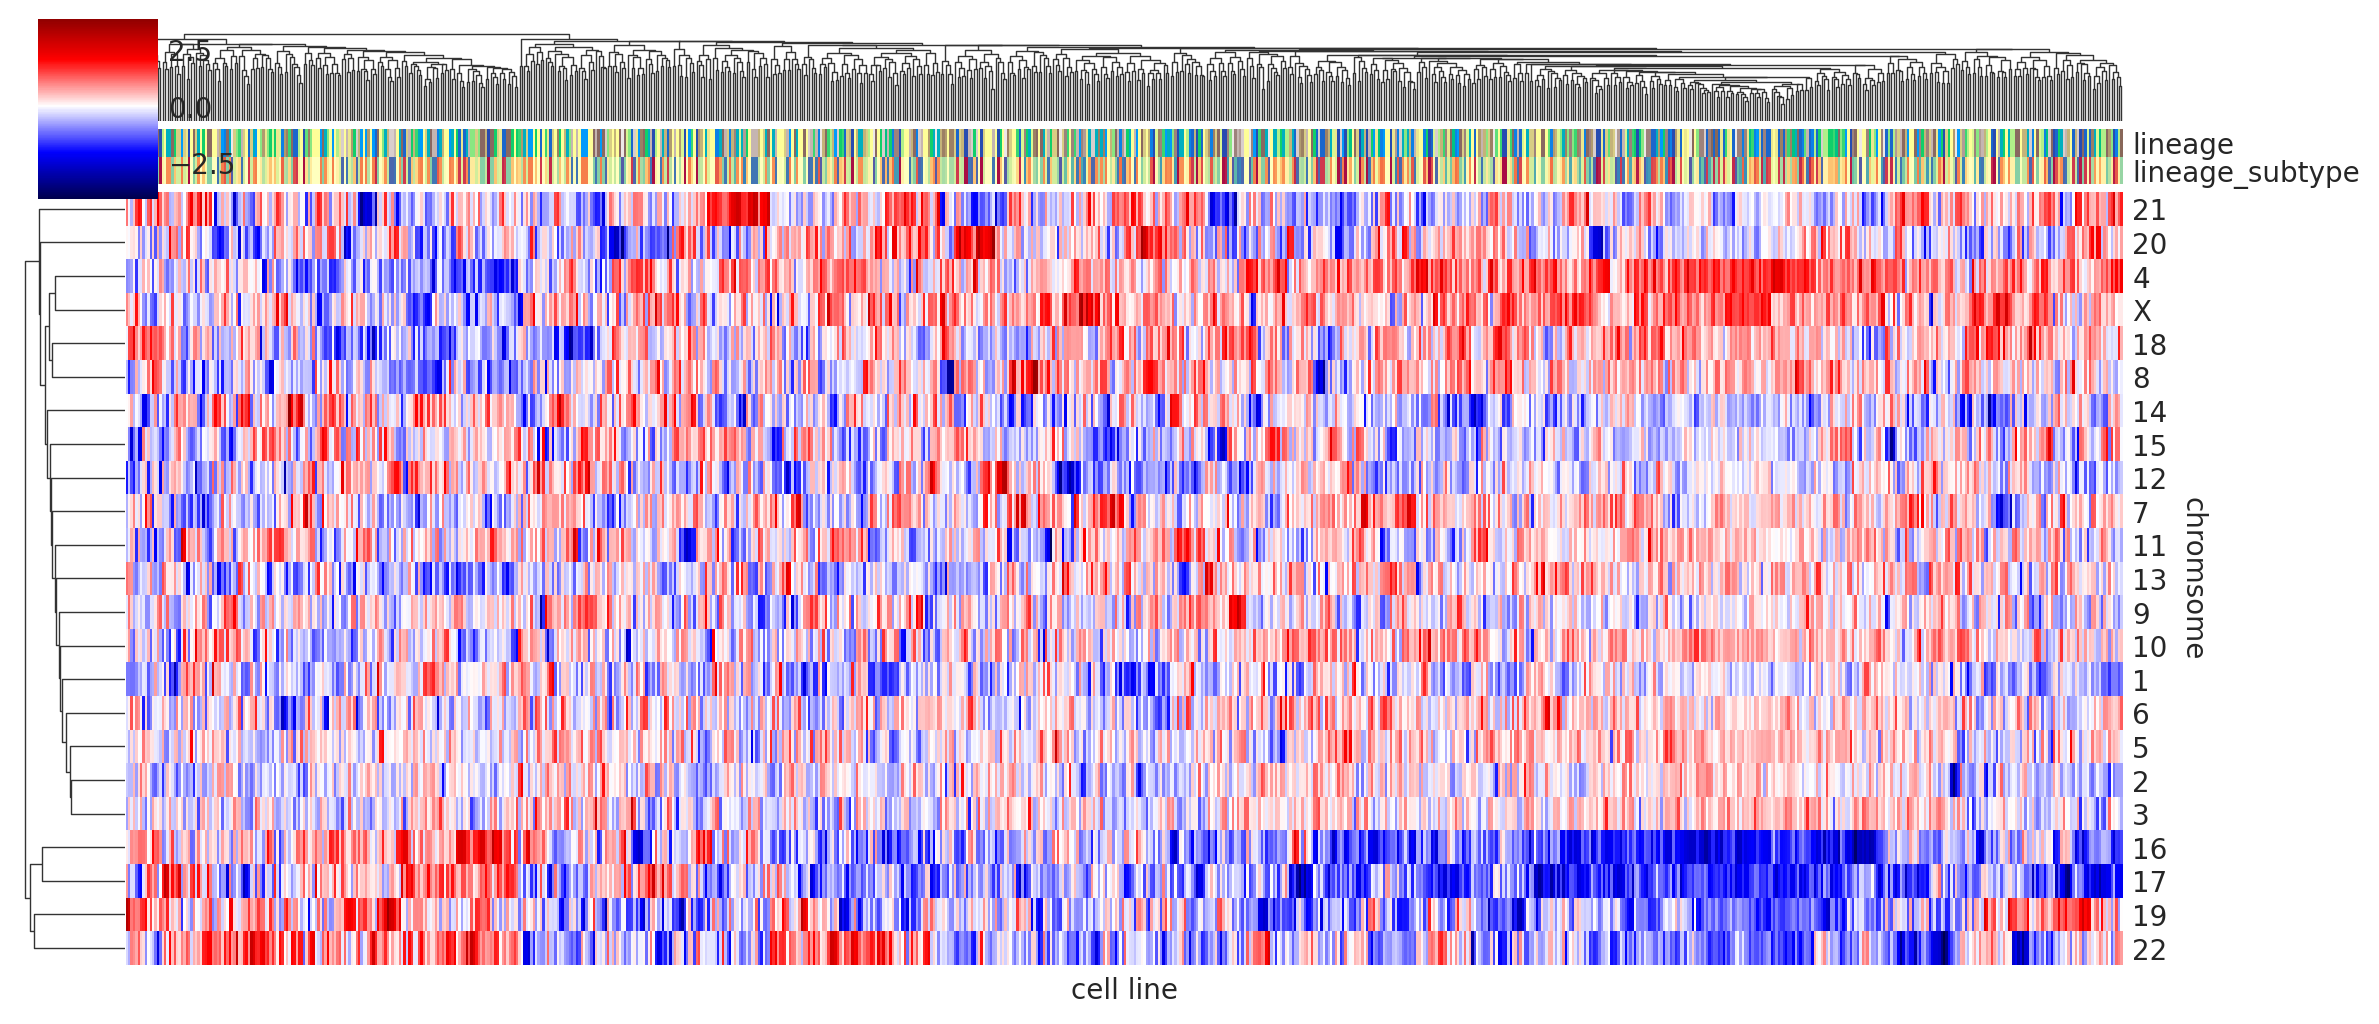

variable: 'm'


/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


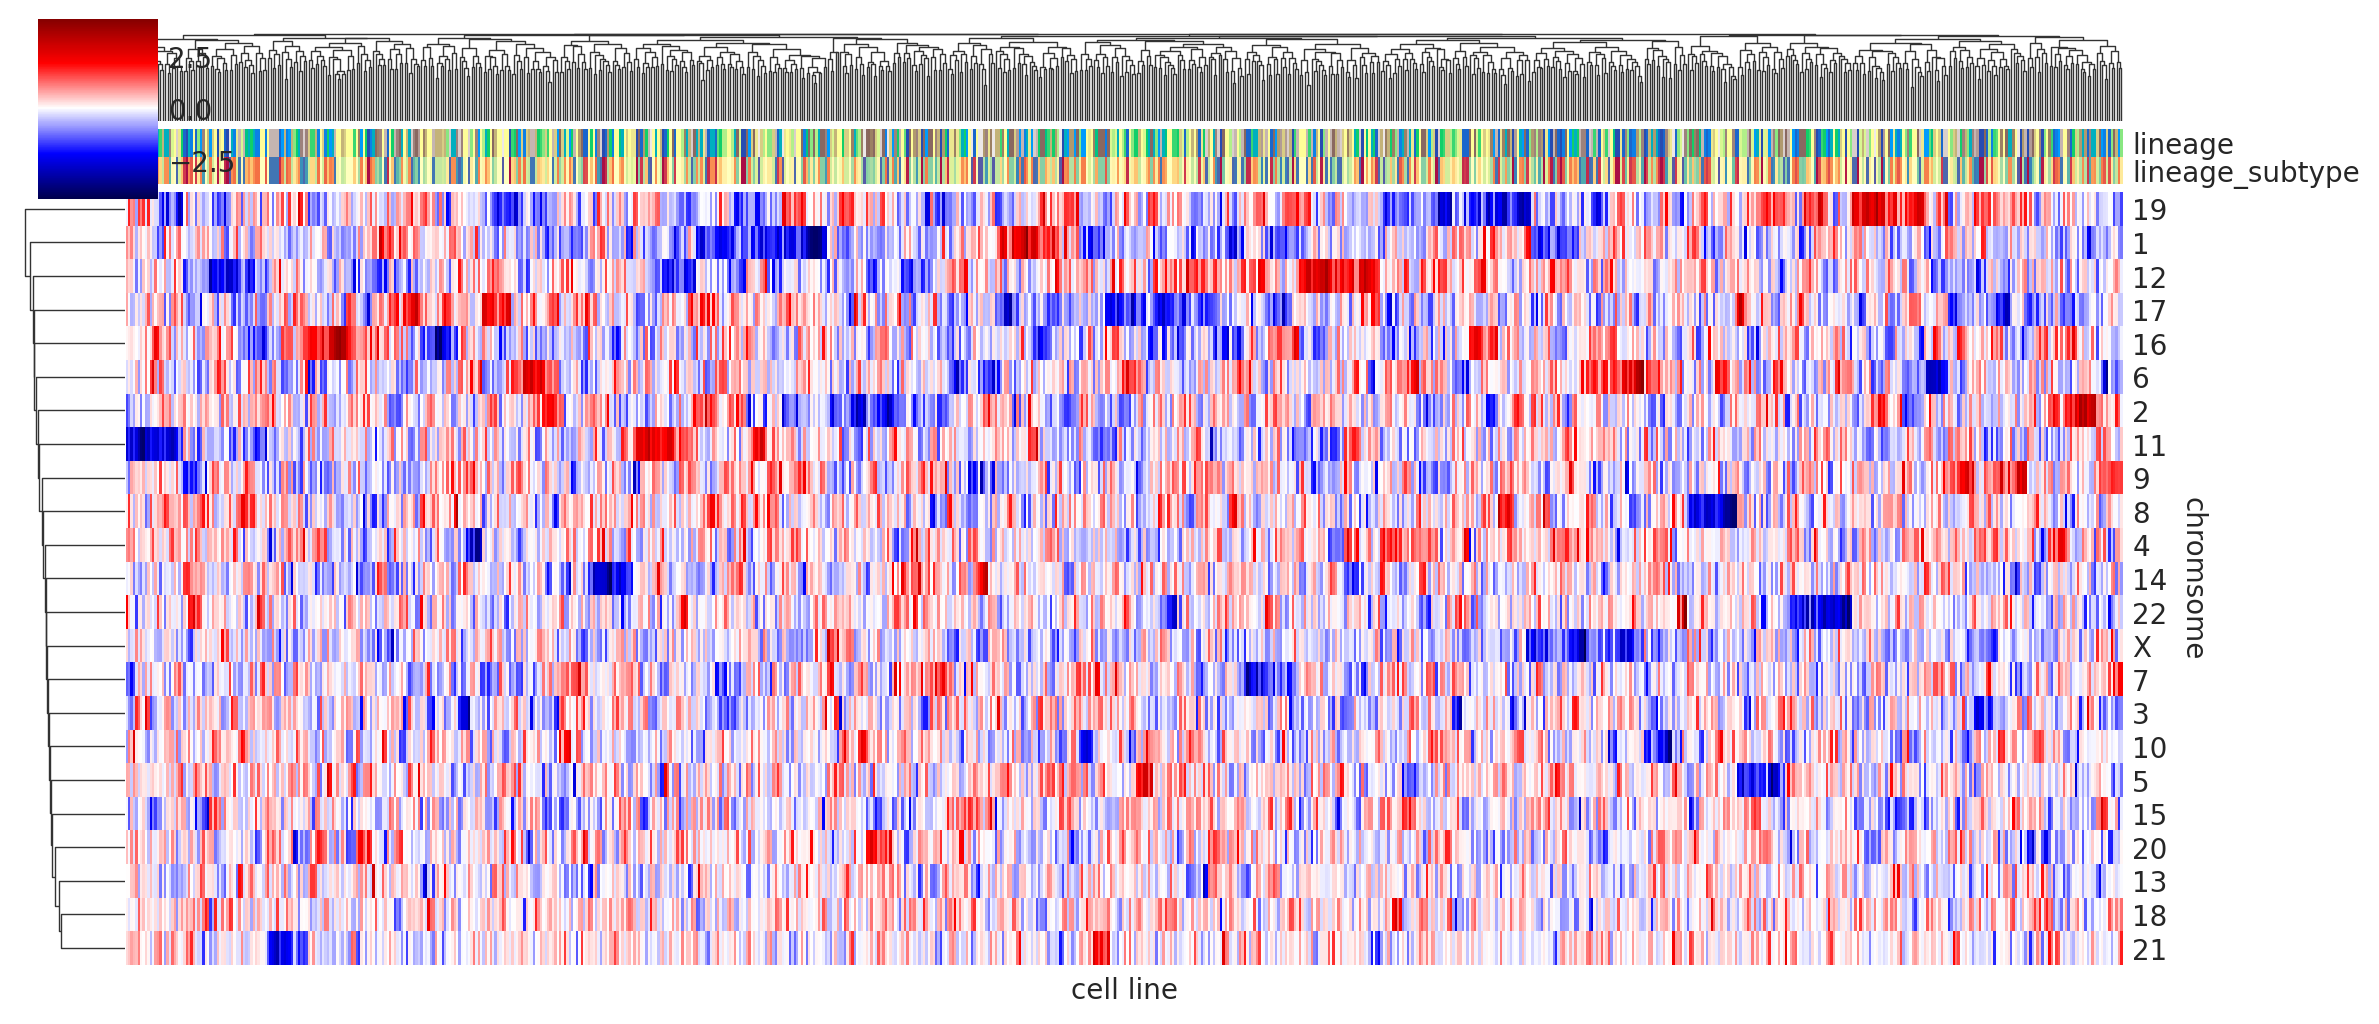

In [57]:
for var_name in ["k", "m"]:
    print(f"variable: '{var_name}'")
    cell_chrom_X = (
        chrom_effects.query(f"var_name == '{var_name}'")
        .pivot_wider(["sgrna_target_chr"], names_from="depmap_id", values_from="mean")
        .set_index("sgrna_target_chr")
    )

    cell_chrom_col_colors = (
        chrom_effects[["depmap_id", "lineage", "lineage_subtype"]]
        .drop_duplicates()
        .set_index("depmap_id")
        .assign(
            lineage=lambda d: d["lineage"].map(lineage_pal),
            lineage_subtype=lambda d: d["lineage_subtype"].map(sublineage_pal),
        )
    )

    cg = sns.clustermap(
        cell_chrom_X,
        cmap="seismic",
        z_score=1,
        center=0,
        # vmin=-0.5,
        # vmax=0.5,
        figsize=(12, 5),
        yticklabels=1,
        col_colors=cell_chrom_col_colors,
        xticklabels=False,
        dendrogram_ratio=(0.05, 0.1),
    )
    cg.ax_heatmap.set_xlabel("cell line")
    cg.ax_heatmap.set_ylabel("chromsome", rotation=270, va="bottom")
    plt.show()

### Compare effects on X chromosome by sex

#### Comparing posterior summaries

In [58]:
cell_line_info = pd.read_csv(data_path(DataFile.DEPMAP_CELL_LINE_INFO)).query(
    "screen == 'broad'"
)

sex_lbls = {True: "M", False: "F", np.nan: "unk."}

cell_line_sex = cell_line_info.assign(sex=lambda d: d["is_male"].map(sex_lbls))[
    ["depmap_id", "sex"]
].drop_duplicates()
cell_line_sex.to_csv(OUTPUT_DIR / "cell-line-sexes.csv")

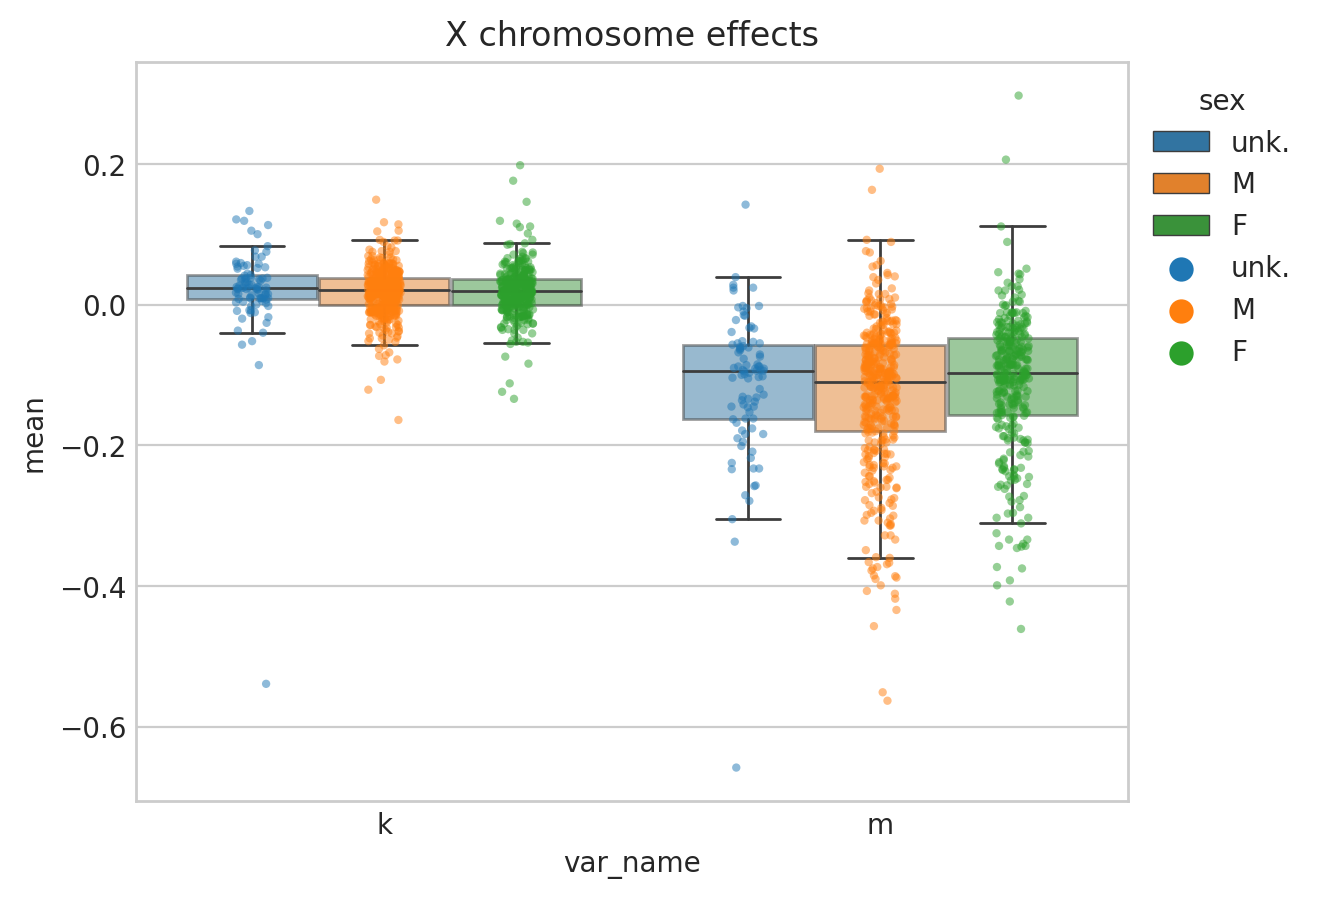

In [59]:
sex_chrom_effects = chrom_effects.query("sgrna_target_chr == 'X'").merge(
    cell_line_sex, on="depmap_id"
)
ax = sns.boxplot(
    data=sex_chrom_effects,
    x="var_name",
    y="mean",
    hue="sex",
    showfliers=False,
    linewidth=1,
    boxprops={"alpha": 0.5},
)
sns.stripplot(
    data=sex_chrom_effects,
    x="var_name",
    y="mean",
    hue="sex",
    dodge=True,
    s=3,
    alpha=0.5,
    ax=ax,
)
ax.legend(title="sex", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("X chromosome effects")
plt.show()

In [60]:
sex_chrom_effects.to_csv(OUTPUT_DIR / "sex-chromosome-differences.csv", index=False)

#### Comparing posterior draws

In [61]:
def x_chromsome_sex_comparison(
    pm: PostDataMan, sex_info: pd.DataFrame, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"x-chrom-comparison-{pm.id}.csv"

    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    try:
        trace = pm.trace
    except AssertionError:
        print(f"No trace for {pm.id}.")
        return pd.DataFrame()

    cells = trace.posterior.coords.get("cell_line").values
    sexes = (
        cell_line_sex.copy()
        .filter_column_isin("depmap_id", cells)
        .filter_column_isin("sex", ["M", "F"])
        .drop_duplicates()
    )

    if sexes["sex"].nunique() < 2:
        print(f"Not both sexes for {pm.id}.")
        return pd.DataFrame()

    sex_chrom_diff: pd.DataFrame | None = None
    for var in ["k", "m"]:
        F_cells = sexes.query("sex == 'F'")["depmap_id"].tolist()
        F_chroms = [f"{c}__X" for c in F_cells]
        F_avgs = trace.posterior.get(var).sel(cell_chrom=F_chroms).mean(axis=(2))

        M_cells = sexes.query("sex == 'M'")["depmap_id"].tolist()
        M_chroms = [f"{c}__X" for c in M_cells]
        M_avgs = trace.posterior.get(var).sel(cell_chrom=M_chroms).mean(axis=(2))

        res = (M_avgs - F_avgs).to_dataframe()
        if sex_chrom_diff is None:
            sex_chrom_diff = res
        else:
            sex_chrom_diff = sex_chrom_diff.merge(
                res, left_index=True, right_index=True
            )

    assert sex_chrom_diff is not None
    sex_chrom_diff = sex_chrom_diff.reset_index(drop=False).assign(
        lineage_subtype=pm.id
    )
    sex_chrom_diff.to_csv(stash_fp, index=False)
    return sex_chrom_diff

In [62]:
x_chrom_comparisons = pd.concat(
    [x_chromsome_sex_comparison(pm, cell_line_sex) for pm in postmen.posteriors]
).reset_index(drop=True)

Not both sexes for blood (CLL).
Not both sexes for breast.
Not both sexes for cervix (cervical carcinoma).
Not both sexes for cervix (cervical squamous).
Not both sexes for ovary (ovary adenocarcinoma).
Not both sexes for prostate.
Not both sexes for soft tissue (liposarcoma).
Not both sexes for soft tissue (synovial sarcoma).
Not both sexes for uterus (endometrial adenocarcinoma).


In [63]:
x_chrom_comparisons.head()

chain  draw         k         m                 lineage_subtype
0      0     0  0.032571  0.008090  bile duct (cholangiocarcinoma)
1      0     1  0.012261 -0.010339  bile duct (cholangiocarcinoma)
2      0     2  0.037411  0.026473  bile duct (cholangiocarcinoma)
3      0     3  0.012975 -0.028039  bile duct (cholangiocarcinoma)
4      0     4  0.020753  0.018815  bile duct (cholangiocarcinoma)

In [64]:
x_chrom_comparisons.to_csv(OUTPUT_DIR / "X-chrom-difference-draws.csv")

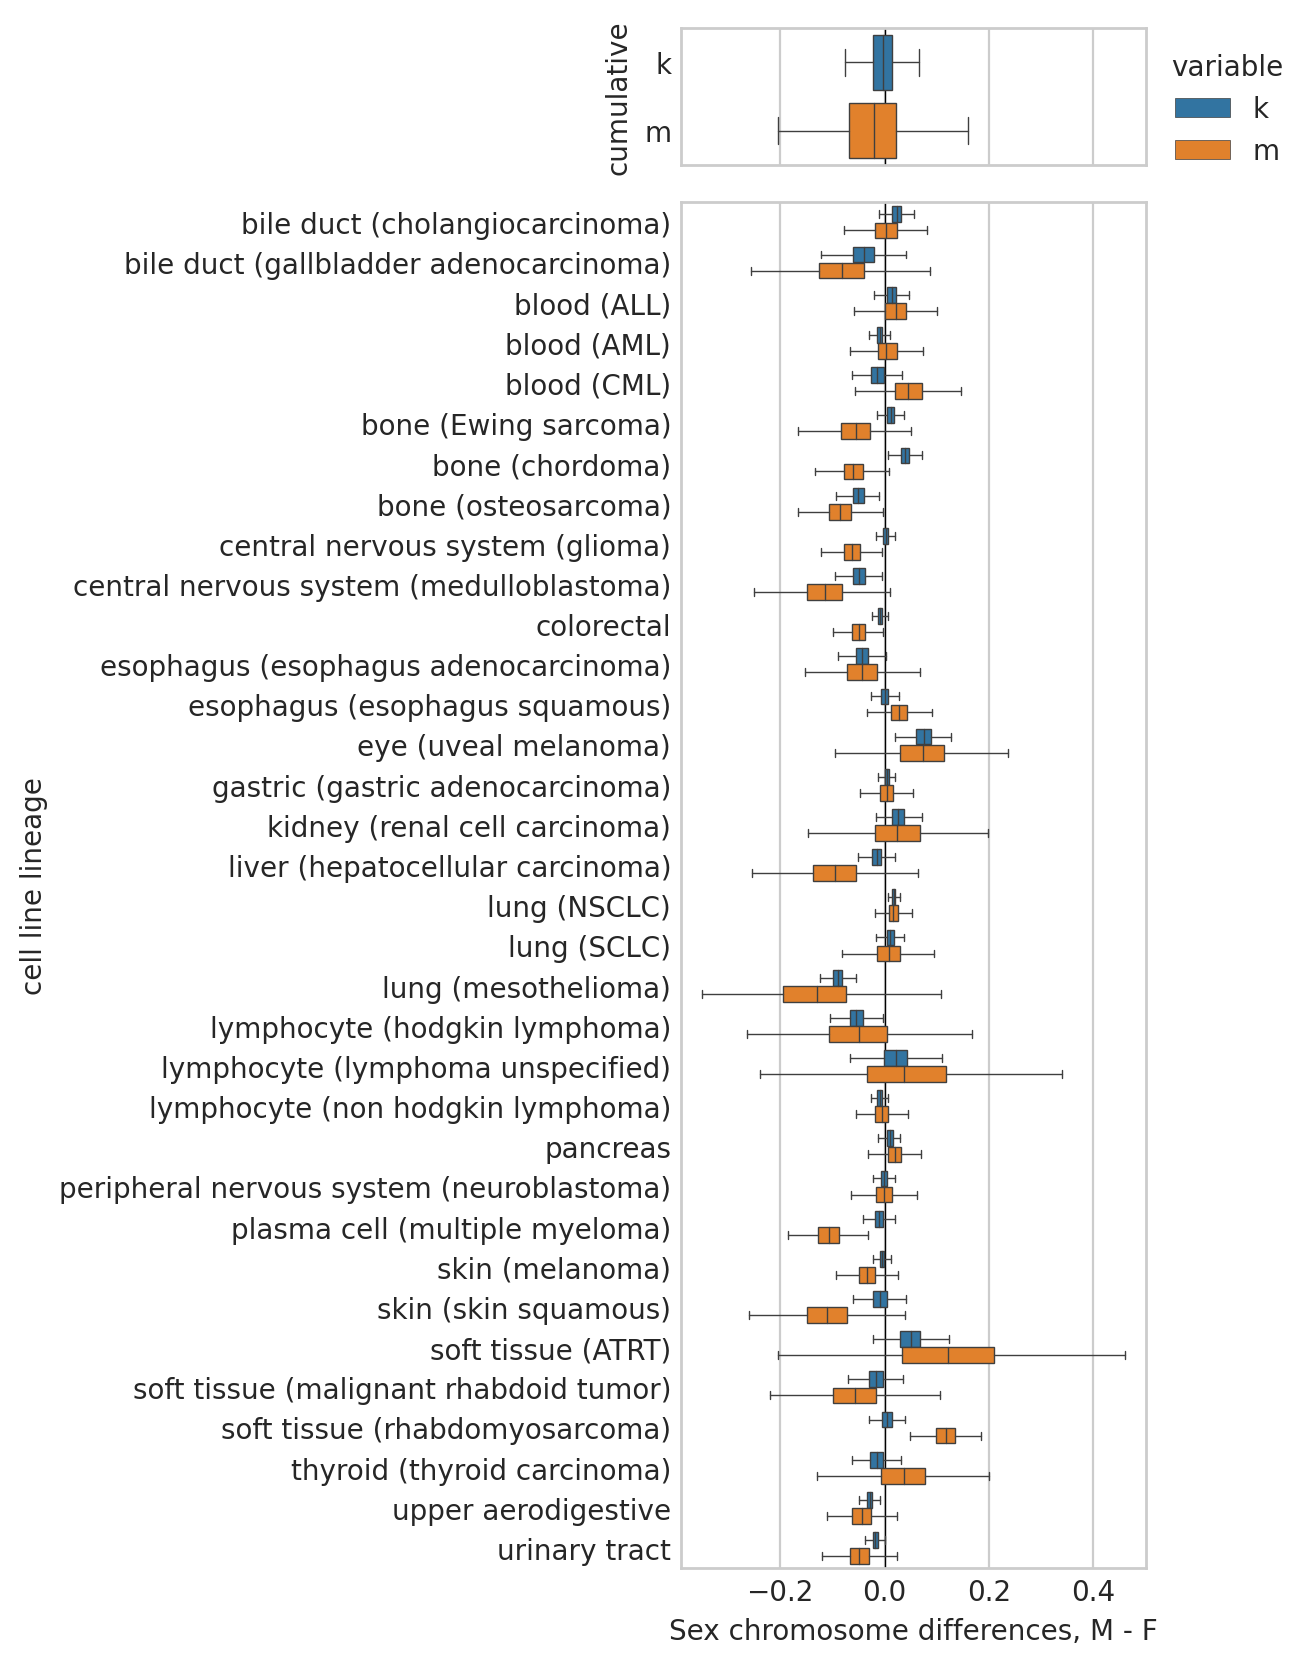

In [65]:
def labels_with_num_sexes(lbl: Text, tp53_df: pd.DataFrame, pm: PostDataMan) -> Text:
    t = lbl.get_text()
    cells = list(pm.trace.posterior.coords.get("cell_line").values)
    n_tp53_muts = (
        tp53_df.query("tp53_null")
        .filter_column_isin("depmap_id", cells)["depmap_id"]
        .nunique()
    )

    if "(" in t:
        t = t.split("(")[1].replace(")", "").strip()

    t = f"{t} ({n_tp53_muts})"
    lbl.set_text(t)
    return lbl


plot_df = (
    x_chrom_comparisons.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["k", "m"])
)

fig, axes = plt.subplots(
    nrows=2,
    figsize=(3, 10),
    sharex=True,
    gridspec_kw={"height_ratios": (1, 10), "hspace": 0.05},
)

ax = axes[0]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="variable",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    dodge=False,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.set_xlabel(None)
ax.set_ylabel("cumulative")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="variable")

ax = axes[1]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="lineage_subtype",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.get_legend().remove()

# xlbls = [
#     labels_with_num_tp53_muts(lbl, tp53_data, postmen[lbl.get_text()])
#     for lbl in ax.get_yticklabels()
# ]
# ax.set_yticklabels(labels=xlbls)
# ax.set_xlim(-0.2, 0.2)
ax.set_ylabel("cell line lineage")
ax.set_xlabel("Sex chromosome differences, M - F")

plt.show()

### TP53 mutants vs WT cell line effects

#### Comparing posterior summaries

In [66]:
def _get_tp53_data(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"tp53-raw-data_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    tp53_genes = ["TP53", "MDM2"]
    res = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            usecols=[
                "lineage",
                "lineage_subtype",
                "depmap_id",
                "hugo_symbol",
                "is_mutated",
                "copy_number",
                "rna_expr",
            ],
            dtype={"rna_expr": "float64"},
        )
        .query("hugo_symbol in @genes", local_dict={"genes": tp53_genes})
        .drop_duplicates()
        .compute()
        .reset_index(drop=True)
    )
    res.to_csv(stash_fp, index=False)
    return res

In [67]:
tp53_data = (
    pd.concat([_get_tp53_data(pm) for pm in postmen.posteriors])
    .reset_index(drop=True)
    .query("hugo_symbol == 'TP53'")
    .reset_index(drop=True)
    .assign(copy_number=lambda d: (2 ** d["copy_number"]) - 1)
)
tp53_data.head()

hugo_symbol   depmap_id  rna_expr  is_mutated  copy_number  \
0        TP53  ACH-000182  4.390255       False     0.561240   
1        TP53  ACH-000209  5.741467       False     1.363992   
2        TP53  ACH-000377  2.805292        True     0.714892   
3        TP53  ACH-000461  7.486553        True     0.838891   
4        TP53  ACH-000976  4.944390        True     0.896567   

      lineage_subtype                         lineage  
0  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
1  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
2  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
3  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
4  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)

In [68]:
tp53_is_mut = []
for _, row in tp53_data.iterrows():
    if row["is_mutated"]:
        tp53_is_mut.append(True)
    elif row["copy_number"] < 0.5:
        tp53_is_mut.append(True)
    elif row["rna_expr"] < 0.0:
        tp53_is_mut.append(True)
    else:
        tp53_is_mut.append(False)

tp53_data["tp53_null"] = tp53_is_mut

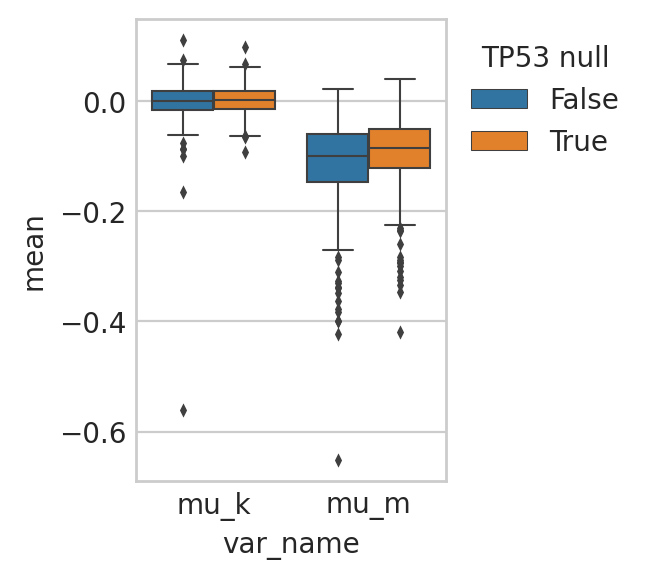

In [69]:
cell_effects_tp53 = cell_effects.merge(
    tp53_data[["depmap_id", "tp53_null"]], on="depmap_id", how="left"
)

plt_df = cell_effects_tp53.copy().reset_index(drop=True)
_cats = (
    plt_df[["lineage", "tp53_null"]]
    .drop_duplicates()
    .groupby("lineage")["tp53_null"]
    .count()
)
_keep_lineages = _cats[_cats > 1].index.tolist()
plt_df = plt_df.filter_column_isin("lineage", _keep_lineages)

_, ax = plt.subplots(figsize=(2, 3))
sns.boxplot(
    data=plt_df,
    x="var_name",
    y="mean",
    hue="tp53_null",
    linewidth=0.75,
    dodge=True,
    fliersize=2,
    ax=ax,
)
ax.legend(title="TP53 null", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [70]:
cell_effects_tp53.to_csv(OUTPUT_DIR / "tp53-mutation-effects.csv", index=False)
tp53_data.to_csv(OUTPUT_DIR / "tp53-mutation-data.csv", index=False)

#### Comparing posterior draws

In [71]:
def tp53_mut_wt_comparison(
    pm: PostDataMan, tp53_muts: pd.DataFrame, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"posterior-dist-tp53-mut-wt_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    try:
        trace = pm.trace
    except AssertionError:
        print(f"No posterior for '{pm.id}.'")
        return pd.DataFrame()

    cells = list(trace.posterior.coords.get("cell_line").values)
    tp53 = tp53_muts.filter_column_isin("depmap_id", cells)[
        ["depmap_id", "tp53_null"]
    ].set_index("depmap_id")
    tp53_mut_idx = tp53.loc[cells]["tp53_null"].values

    if np.all(tp53_mut_idx) or not np.any(tp53_mut_idx):
        print(f"Skipping '{pm.id}'.")
        return pd.DataFrame()

    res: pd.DataFrame | None = None
    for v in ["mu_k", "mu_m"]:
        var = trace.posterior.get(v)
        muts = var[:, :, tp53_mut_idx].mean(axis=(2))
        wts = var[:, :, ~tp53_mut_idx].mean(axis=(2))
        mut_wt_diff = (muts - wts).to_dataframe()
        if res is None:
            res = mut_wt_diff
        else:
            res = res.merge(mut_wt_diff, left_index=True, right_index=True)

    assert res is not None
    res = res.reset_index(drop=False).assign(lineage_subtype=pm.id)
    res.to_csv(stash_fp, index=False)
    return res

In [72]:
tp53_draw_diffs = pd.concat(
    [tp53_mut_wt_comparison(pm, tp53_data.copy()) for pm in postmen.posteriors]
).reset_index(drop=True)

Skipping 'blood (CML)'.
Skipping 'esophagus (esophagus adenocarcinoma)'.
Skipping 'esophagus (esophagus squamous)'.
Skipping 'eye (uveal melanoma)'.
Skipping 'lung (SCLC)'.
Skipping 'soft tissue (malignant rhabdoid tumor)'.
Skipping 'thyroid (thyroid carcinoma)'.


In [73]:
tp53_draw_diffs.to_csv(OUTPUT_DIR / "tp53-difference-draws.csv")

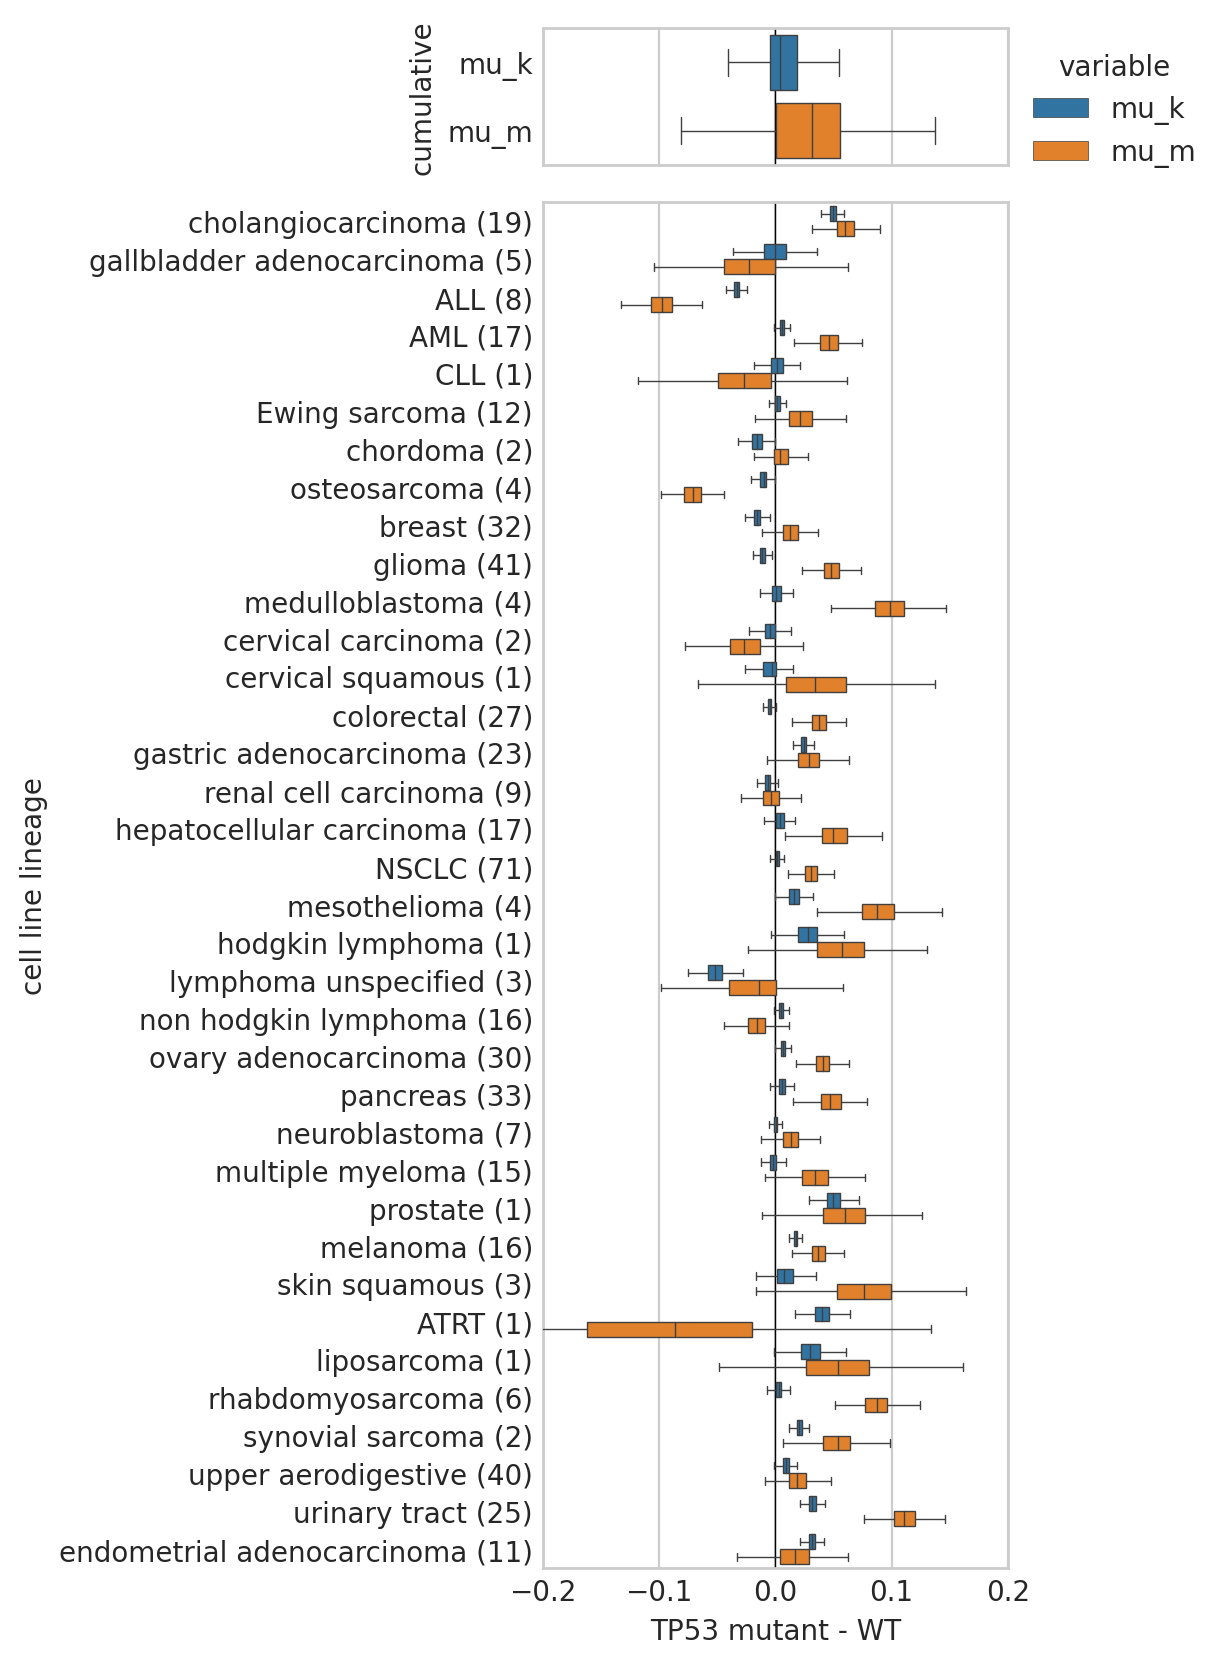

In [74]:
def labels_with_num_tp53_muts(
    lbl: Text, tp53_df: pd.DataFrame, pm: PostDataMan
) -> Text:
    t = lbl.get_text()
    cells = list(pm.trace.posterior.coords.get("cell_line").values)
    n_tp53_muts = (
        tp53_df.query("tp53_null")
        .filter_column_isin("depmap_id", cells)["depmap_id"]
        .nunique()
    )

    if "(" in t:
        t = t.split("(")[1].replace(")", "").strip()

    t = f"{t} ({n_tp53_muts})"
    lbl.set_text(t)
    return lbl


plot_df = (
    tp53_draw_diffs.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["mu_k", "mu_m"])
)

fig, axes = plt.subplots(
    nrows=2,
    figsize=(3, 10),
    sharex=True,
    gridspec_kw={"height_ratios": (1, 10), "hspace": 0.05},
)

ax = axes[0]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="variable",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    dodge=False,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.set_xlabel(None)
ax.set_ylabel("cumulative")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="variable")

ax = axes[1]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="lineage_subtype",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.get_legend().remove()

xlbls = [
    labels_with_num_tp53_muts(lbl, tp53_data, postmen[lbl.get_text()])
    for lbl in ax.get_yticklabels()
]
ax.set_yticklabels(labels=xlbls)  # , rotation=60, ha="right")
ax.set_xlim(-0.2, 0.2)
ax.set_ylabel("cell line lineage")
ax.set_xlabel("TP53 mutant - WT")

plt.show()

---

In [75]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 13.75 minutes


In [76]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-26

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-171.o2.rc.hms.harvard.edu

Git branch: figures

numpy     : 1.23.3
json      : 2.0.9
seaborn   : 0.11.2
matplotlib: 3.5.3
dask      : 2022.9.0
pandas    : 1.4.4

